In [ ]:
# %%capture
!pip install lightgbm river --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 87.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.47.0 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incom

In [2]:
import os, gc, warnings, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.manifold import TSNE
from scipy.stats import ks_2samp, wasserstein_distance, wilcoxon
import lightgbm as lgb

from river import forest as river_forest

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("[OK] All libraries imported (including River for ARF).")

[OK] All libraries imported (including River for ARF).


In [ ]:
class Config:
    seed = 42
    data_dir = "/kaggle/input/unsw-nb15"

    train_file    = "UNSW_NB15_training-set.csv"
    test_file     = "UNSW_NB15_testing-set.csv"
    features_file = "NUSW-NB15_features.csv"
    raw_files     = ["UNSW-NB15_1.csv", "UNSW-NB15_2.csv",
                     "UNSW-NB15_3.csv", "UNSW-NB15_4.csv"]

    n_batches              = 8
    drift_pvalue_threshold = 0.05
    sliding_window_size    = 3
    fixed_attack_rate      = 0.45

    rf_params = dict(n_estimators=200, max_depth=20, min_samples_split=5,
                     min_samples_leaf=2, n_jobs=-1, random_state=42,
                     class_weight='balanced')
    sgd_params = dict(loss='log_loss', penalty='l2', alpha=1e-4,
                      max_iter=1, warm_start=True, random_state=42,
                      learning_rate='adaptive', eta0=0.01)
    arf_params = dict(n_models=25, max_depth=15, seed=42)
    gem_memory_per_batch = 300
    gem_epochs = 5

    drift_attack_groups = {
        'early': ['Generic','Exploits','Fuzzers'],
        'mid':   ['DoS','Reconnaissance'],
        'late':  ['Backdoors','Shellcode','Worms','Analysis','Backdoor']
    }
    feature_drift_configs = [
        (2,'sbytes',1.8,0.5),(2,'dbytes',1.8,0.5),
        (4,'sload',2.5,0.8),(4,'dload',2.5,0.8),
        (5,'rate',0.3,-0.4),(5,'dur',2.5,0.6),
    ]
    noise_scale_per_batch = [0.0,0.01,0.03,0.06,0.10,0.15,0.22,0.30]
    attack_mix = [
        [1.00,0.00,0.00],[0.85,0.15,0.00],[0.60,0.35,0.05],[0.35,0.40,0.25],
        [0.15,0.30,0.55],[0.08,0.17,0.75],[0.04,0.08,0.88],[0.02,0.03,0.95],
    ]

cfg = Config()

print("Files in dataset:")
for f in sorted(os.listdir(cfg.data_dir)):
    sz = os.path.getsize(os.path.join(cfg.data_dir, f)) / 1e6
    print(f"   {f}  ({sz:.1f} MB)")
print(f"\nPlan: {cfg.n_batches} batches, attack rate FIXED {cfg.fixed_attack_rate:.0%}")
print("Metrics: AA, FM, BWT  |  Methods: Static RF, Sliding Window, ARF, GEM")

Files in dataset:
   NUSW-NB15_features.csv  (0.0 MB)
   UNSW-NB15_1.csv  (169.0 MB)
   UNSW-NB15_2.csv  (165.2 MB)
   UNSW-NB15_3.csv  (154.6 MB)
   UNSW-NB15_4.csv  (97.6 MB)
   UNSW-NB15_LIST_EVENTS.csv  (0.0 MB)
   UNSW_NB15_testing-set.csv  (32.3 MB)
   UNSW_NB15_training-set.csv  (15.4 MB)

Plan: 8 batches, attack rate FIXED 45%
Metrics: AA, FM, BWT  |  Methods: Static RF, Sliding Window, ARF, GEM


In [ ]:
print("="*60)
print("LOADING DATA")
print("="*60)

df_train = pd.read_csv(os.path.join(cfg.data_dir, cfg.train_file), low_memory=False)
df_test  = pd.read_csv(os.path.join(cfg.data_dir, cfg.test_file),  low_memory=False)
print(f"Train: {df_train.shape[0]:>8,} x {df_train.shape[1]}")
print(f"Test:  {df_test.shape[0]:>8,} x {df_test.shape[1]}")

features_path = os.path.join(cfg.data_dir, cfg.features_file)
raw_col_names = None
if os.path.exists(features_path):
    for enc in ['latin-1','cp1252','iso-8859-1','utf-8']:
        try:
            feat_df = pd.read_csv(features_path, encoding=enc)
            raw_col_names = feat_df['Name'].str.strip().tolist()
            print(f"[OK] Feature names loaded ({len(raw_col_names)})")
            break
        except: continue

raw_dfs = []
for rf in cfg.raw_files:
    rpath = os.path.join(cfg.data_dir, rf)
    if os.path.exists(rpath):
        try:
            rdf = pd.read_csv(rpath, header=None, low_memory=False)
            raw_dfs.append(rdf)
            print(f"   {rf}: {len(rdf):,} rows")
        except Exception as e:
            print(f"   Failed {rf}: {e}")

df_raw = None
if raw_dfs:
    df_raw_combined = pd.concat(raw_dfs, ignore_index=True)
    if raw_col_names:
        ncols = df_raw_combined.shape[1]
        if len(raw_col_names) >= ncols - 2:
            col_names = raw_col_names[:ncols-2] + ['attack_cat','label']
            if len(col_names) == ncols:
                df_raw_combined.columns = col_names
            else:
                col_names = [f'col_{i}' for i in range(ncols)]
                col_names[-1]='label'; col_names[-2]='attack_cat'
                df_raw_combined.columns = col_names
        else:
            col_names = [f'col_{i}' for i in range(ncols)]
            col_names[-1]='label'; col_names[-2]='attack_cat'
            df_raw_combined.columns = col_names
    if 'Label' in df_raw_combined.columns and 'label' not in df_raw_combined.columns:
        df_raw_combined.rename(columns={'Label':'label'}, inplace=True)
    df_raw_combined['label'] = pd.to_numeric(df_raw_combined['label'], errors='coerce')
    df_raw_combined = df_raw_combined.dropna(subset=['label'])
    df_raw_combined['label'] = df_raw_combined['label'].astype(int)
    if 'attack_cat' in df_raw_combined.columns:
        df_raw_combined['attack_cat'] = df_raw_combined['attack_cat'].astype(str).str.strip()
    df_raw = df_raw_combined
    print(f"Raw combined: {len(df_raw):,} rows")
    del raw_dfs, df_raw_combined; gc.collect()

LOADING DATA
Train:   82,332 x 45
Test:   175,341 x 45
[OK] Feature names loaded (49)
   UNSW-NB15_1.csv: 700,001 rows
   UNSW-NB15_2.csv: 700,001 rows
   UNSW-NB15_3.csv: 700,001 rows
   UNSW-NB15_4.csv: 440,044 rows
Raw combined: 2,540,047 rows


In [ ]:
print("="*60)
print("PART 1: EXPLORATORY DATA ANALYSIS")
print("="*60)

for name, df in [("TRAIN", df_train), ("TEST", df_test)]:
    print(f"\n--- {name} ---")
    print(f"Shape: {df.shape}")
    print(f"Label: {dict(df['label'].value_counts())}")
    if 'attack_cat' in df.columns:
        atk = df[df['label']==1]['attack_cat'].astype(str).str.strip().value_counts()
        print(f"Attack types:\n{atk.to_string()}")

print("\n--- Attack Group Pool Sizes ---")
all_sources = [df_train, df_test]
if df_raw is not None: all_sources.append(df_raw)
df_pool = pd.concat(all_sources, ignore_index=True)
df_pool['attack_cat'] = df_pool['attack_cat'].astype(str).str.strip() if 'attack_cat' in df_pool.columns else ''
df_pool['label'] = pd.to_numeric(df_pool['label'], errors='coerce').fillna(0).astype(int)
for grp, cats in cfg.drift_attack_groups.items():
    mask = df_pool['attack_cat'].isin(cats) & (df_pool['label']==1)
    print(f"   {grp:>6}: {mask.sum():>8,}  {cats}")
print(f"   normal: {(df_pool['label']==0).sum():>8,}")

PART 1: EXPLORATORY DATA ANALYSIS

--- TRAIN ---
Shape: (82332, 45)
Label: {1: np.int64(45332), 0: np.int64(37000)}
Attack types:
attack_cat
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44

--- TEST ---
Shape: (175341, 45)
Label: {1: np.int64(119341), 0: np.int64(56000)}
Attack types:
attack_cat
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130

--- Attack Group Pool Sizes ---
    early:  411,894  ['Generic', 'Exploits', 'Fuzzers']
      mid:   60,680  ['DoS', 'Reconnaissance']
     late:   13,382  ['Backdoors', 'Shellcode', 'Worms', 'Analysis', 'Backdoor']
   normal: 2,311,764


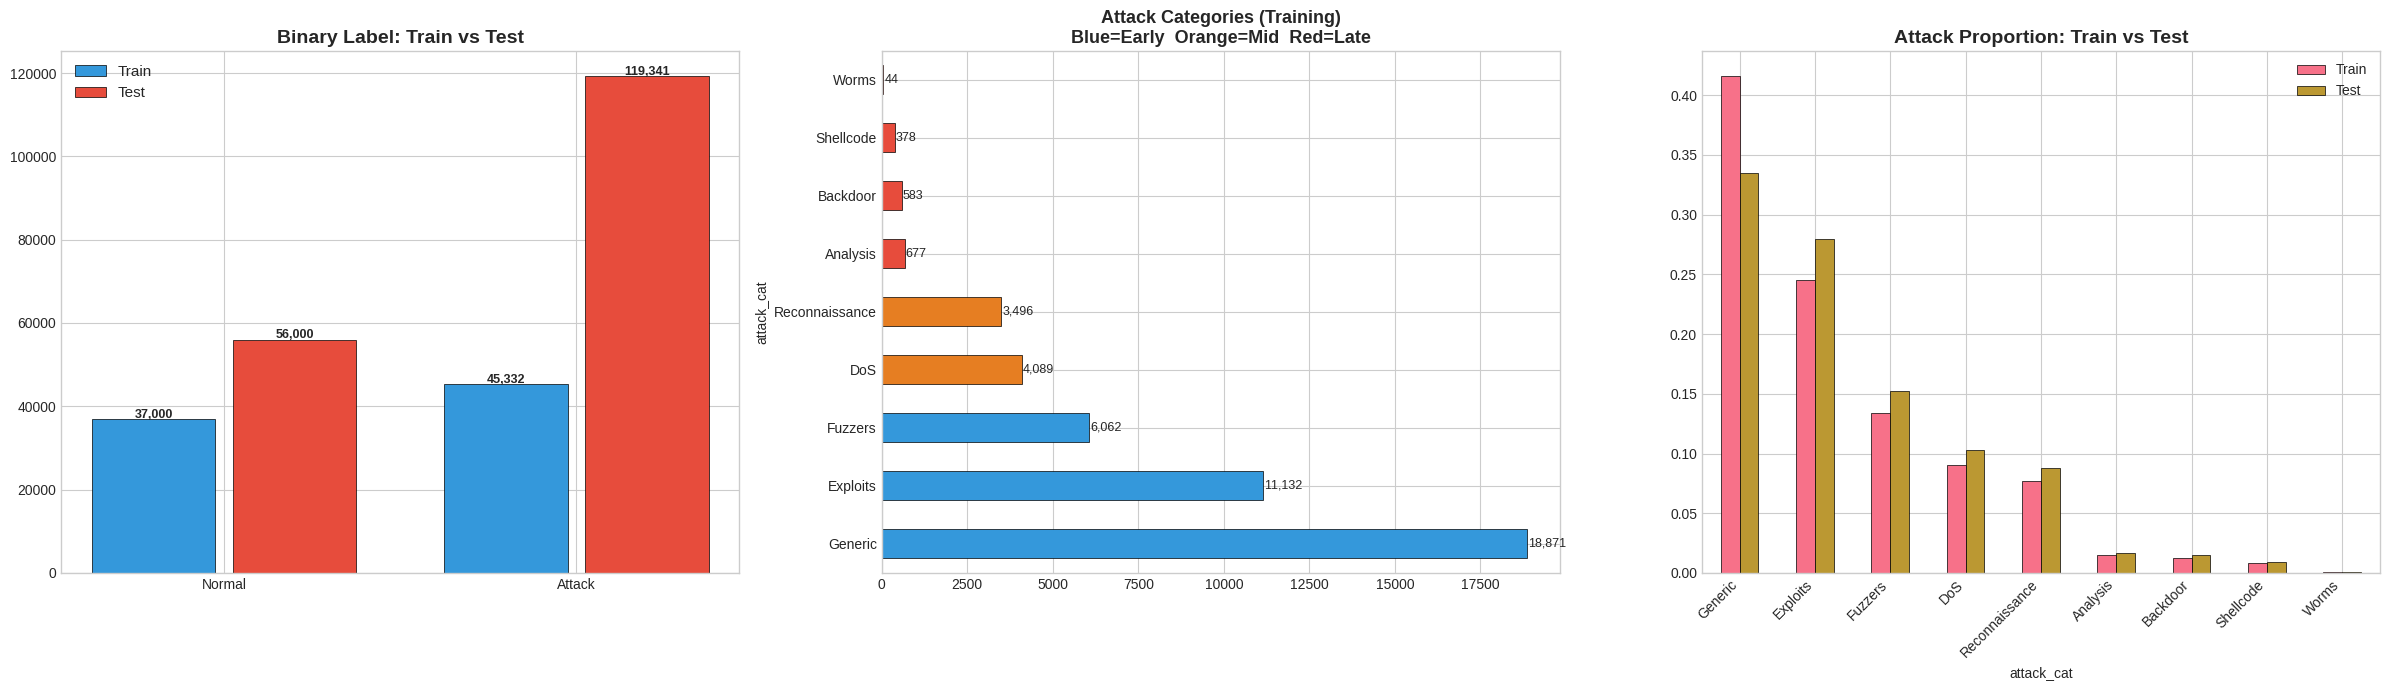

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

ax = axes[0]
for df_name, df_cur, clr in [('Train',df_train,'#3498db'),('Test',df_test,'#e74c3c')]:
    counts = df_cur['label'].value_counts().sort_index()
    offset = 0.2 if df_name=='Test' else -0.2
    bars = ax.bar(np.arange(2)+offset, counts.values, width=0.35,
                  label=df_name, color=clr, edgecolor='black', linewidth=0.5)
    for bar, cnt in zip(bars, counts.values):
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+300,
                f'{cnt:,}', ha='center', fontsize=9, fontweight='bold')
ax.set_xticks([0,1]); ax.set_xticklabels(['Normal','Attack'])
ax.set_title('Binary Label: Train vs Test', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)

ax = axes[1]
cats = df_train[df_train['label']==1]['attack_cat'].astype(str).str.strip()
cc = cats.value_counts()
grp_c = {}
for cat in cc.index:
    if cat in cfg.drift_attack_groups['early']: grp_c[cat]='#3498db'
    elif cat in cfg.drift_attack_groups['mid']: grp_c[cat]='#e67e22'
    elif cat in cfg.drift_attack_groups['late']: grp_c[cat]='#e74c3c'
    else: grp_c[cat]='#95a5a6'
cc.plot(kind='barh', ax=ax, color=[grp_c.get(c,'#95a5a6') for c in cc.index],
        edgecolor='black', linewidth=0.5)
ax.set_title('Attack Categories (Training)\nBlue=Early  Orange=Mid  Red=Late',
             fontsize=13, fontweight='bold')
for i, v in enumerate(cc.values):
    ax.text(v+30, i, f'{v:,}', va='center', fontsize=9)

ax = axes[2]
tr_p = df_train[df_train['label']==1]['attack_cat'].astype(str).str.strip().value_counts(normalize=True)
te_p = df_test[df_test['label']==1]['attack_cat'].astype(str).str.strip().value_counts(normalize=True)
pd.DataFrame({'Train':tr_p,'Test':te_p}).fillna(0).plot(kind='bar', ax=ax,
    edgecolor='black', linewidth=0.5)
ax.set_title('Attack Proportion: Train vs Test', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout(); plt.savefig('eda_01_attacks.png', dpi=150, bbox_inches='tight'); plt.show()

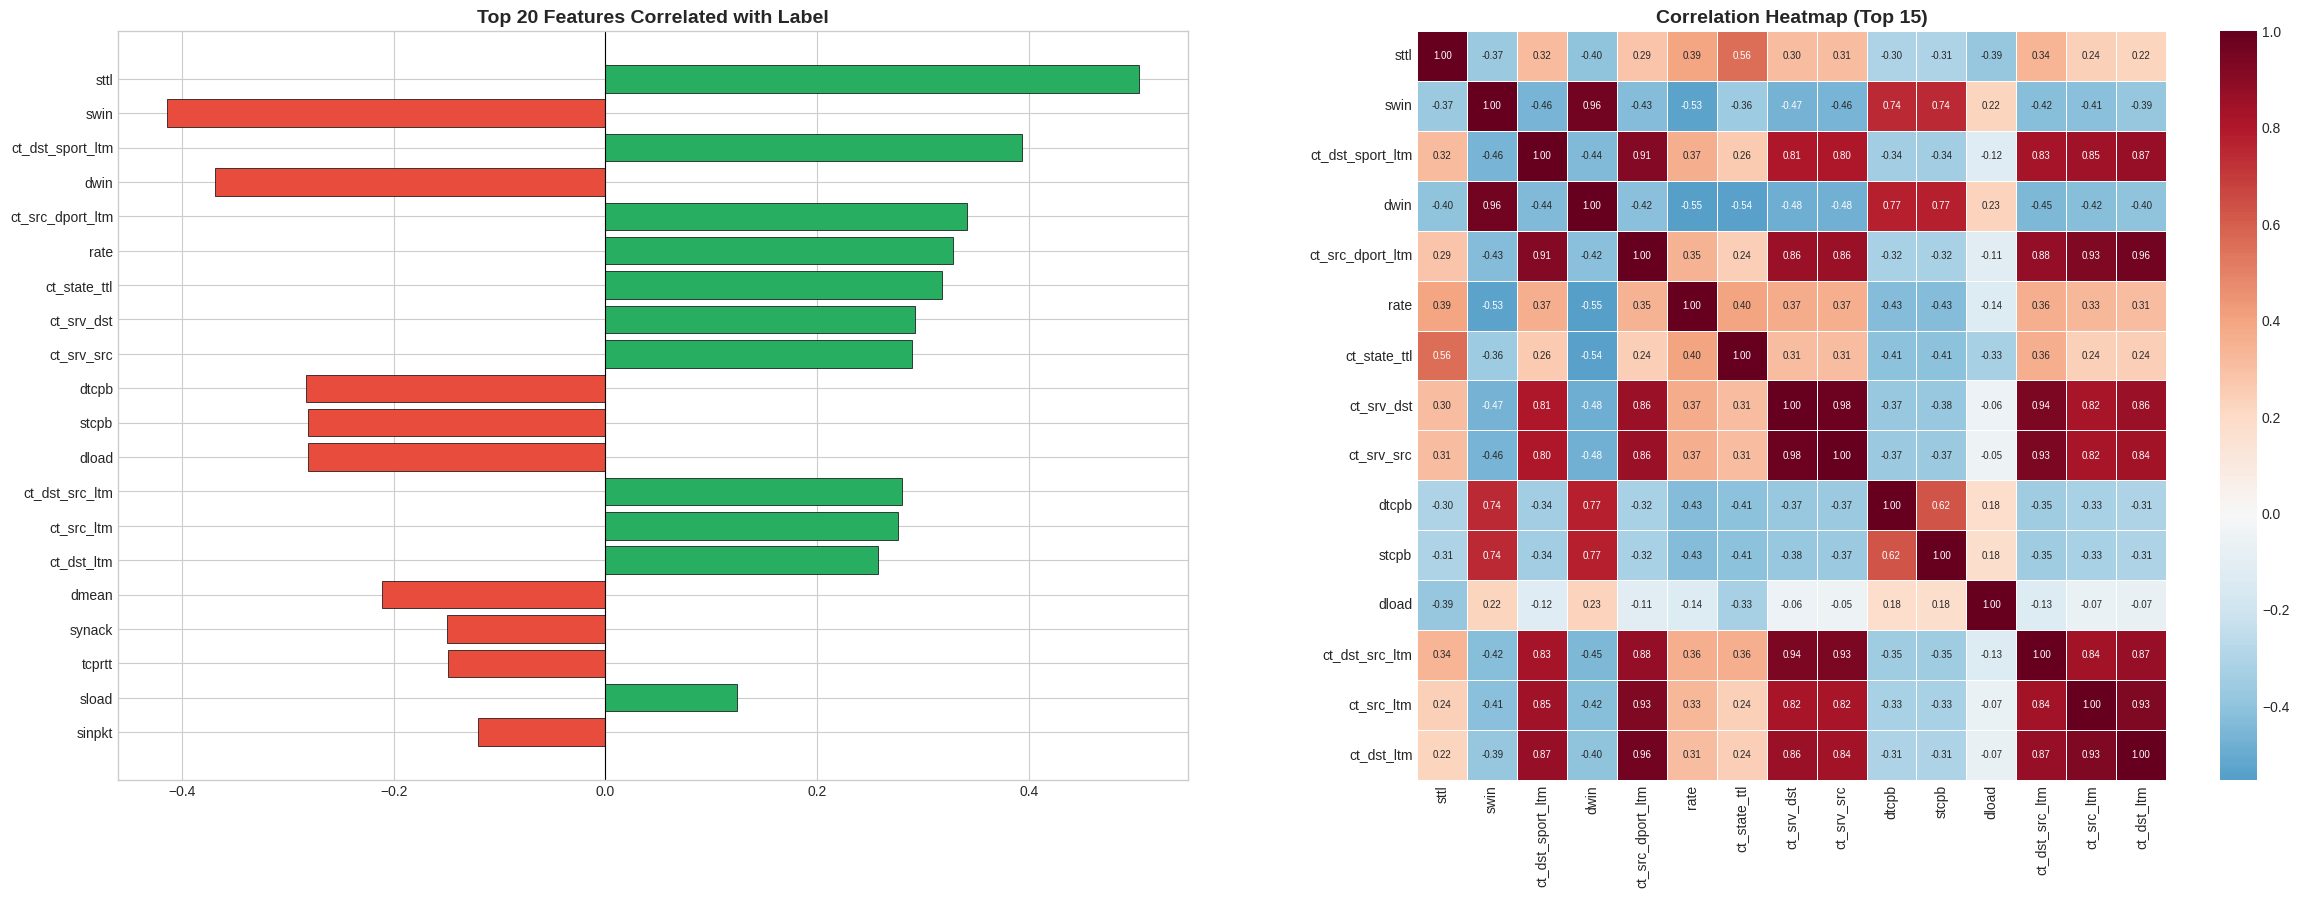

In [ ]:
num_cols = [c for c in df_train.select_dtypes(include=[np.number]).columns if c not in ['id','label']]
corr_label = df_train[num_cols+['label']].corr()['label'].drop('label', errors='ignore')
top20 = corr_label.abs().sort_values(ascending=False).head(20).index.tolist()

fig, axes = plt.subplots(1, 2, figsize=(24, 9))
ax = axes[0]
bar_c = ['#e74c3c' if corr_label[f]<0 else '#27ae60' for f in top20]
y_pos = list(range(len(top20)-1,-1,-1))
ax.barh(y_pos, [corr_label[f] for f in top20], color=bar_c, edgecolor='black', linewidth=0.5)
ax.set_yticks(y_pos); ax.set_yticklabels(top20)
ax.set_title('Top 20 Features Correlated with Label', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)

ax = axes[1]
sns.heatmap(df_train[top20[:15]].corr(), annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, ax=ax, annot_kws={'size':7})
ax.set_title('Correlation Heatmap (Top 15)', fontsize=14, fontweight='bold')

plt.tight_layout(); plt.savefig('eda_02_correlation.png', dpi=150, bbox_inches='tight'); plt.show()

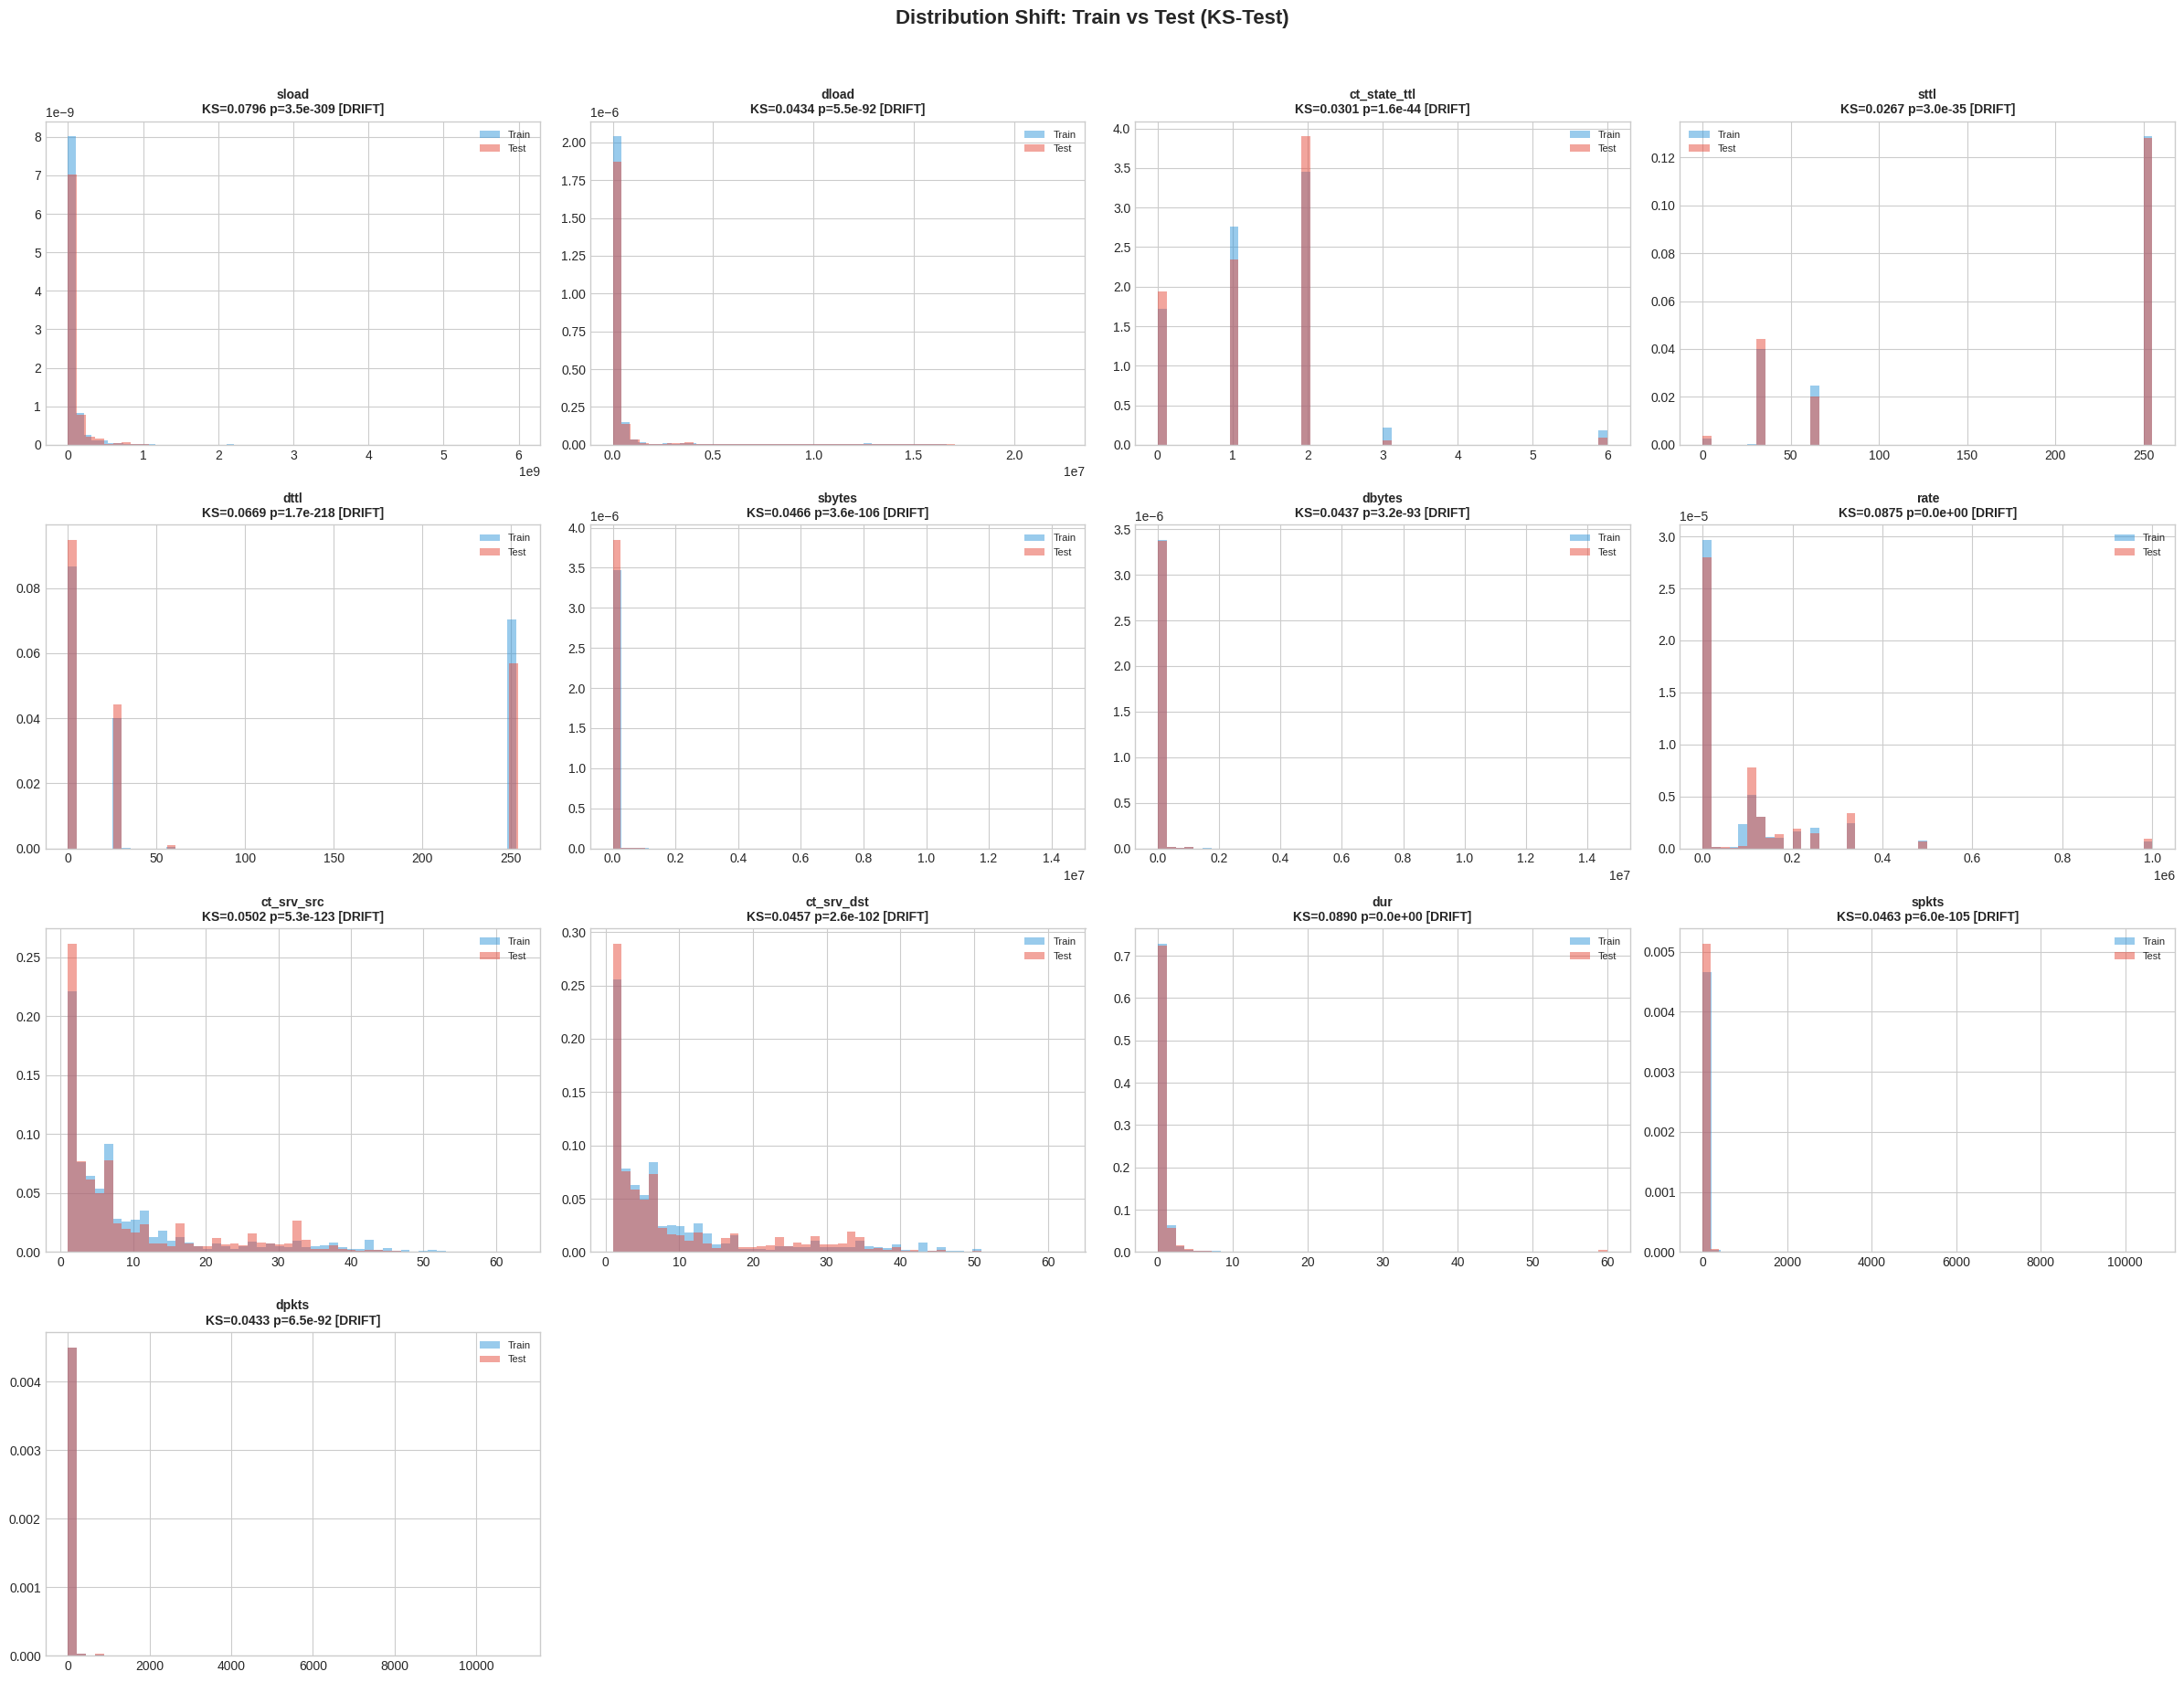


KS-Test Summary:
Feature                    KS            p   Drift?
--------------------------------------------------
dur                    0.0890     0.00e+00      YES
rate                   0.0875     0.00e+00      YES
sload                  0.0796    3.50e-309      YES
dttl                   0.0669    1.72e-218      YES
ct_srv_src             0.0502    5.28e-123      YES
sbytes                 0.0466    3.64e-106      YES
spkts                  0.0463    6.04e-105      YES
ct_srv_dst             0.0457    2.56e-102      YES
dbytes                 0.0437     3.17e-93      YES
dload                  0.0434     5.55e-92      YES
dpkts                  0.0433     6.48e-92      YES
ct_state_ttl           0.0301     1.57e-44      YES
sttl                   0.0267     3.02e-35      YES


In [ ]:
key_feats = [f for f in ['sload','dload','ct_state_ttl','sttl','dttl','sbytes','dbytes',
             'rate','ct_srv_src','ct_srv_dst','dur','spkts','dpkts']
             if f in df_train.columns and f in df_test.columns]

n = len(key_feats); nc=4; nr=(n+3)//4
fig, axes = plt.subplots(nr, nc, figsize=(24, 4.5*nr))
axes_flat = axes.flatten()
drift_report = {}
for idx, feat in enumerate(key_feats):
    ax = axes_flat[idx]
    tr = pd.to_numeric(df_train[feat], errors='coerce').dropna().values
    te = pd.to_numeric(df_test[feat], errors='coerce').dropna().values
    ks_stat, ks_p = ks_2samp(tr, te)
    drift_report[feat] = {'ks':ks_stat,'p':ks_p}
    ax.hist(tr, bins=50, alpha=0.5, label='Train', density=True, color='#3498db')
    ax.hist(te, bins=50, alpha=0.5, label='Test', density=True, color='#e74c3c')
    tag = "DRIFT" if ks_p < cfg.drift_pvalue_threshold else "OK"
    ax.set_title(f'{feat}\nKS={ks_stat:.4f} p={ks_p:.1e} [{tag}]', fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
for idx in range(n, len(axes_flat)): axes_flat[idx].set_visible(False)
plt.suptitle('Distribution Shift: Train vs Test (KS-Test)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(); plt.savefig('eda_03_shift.png', dpi=150, bbox_inches='tight'); plt.show()

print("\nKS-Test Summary:")
print(f"{'Feature':<20} {'KS':>8} {'p':>12} {'Drift?':>8}")
print("-"*50)
for f, r in sorted(drift_report.items(), key=lambda x: x[1]['ks'], reverse=True):
    print(f"{f:<20} {r['ks']:>8.4f} {r['p']:>12.2e} {'YES' if r['p']<0.05 else 'No':>8}")

In [ ]:
def preprocess(df, label_encoders=None, scaler=None, fit=True):
    df = df.copy()
    y = df['label'].astype(int).values if 'label' in df.columns else None
    attack_cat = df['attack_cat'].astype(str).str.strip().values if 'attack_cat' in df.columns else None
    drop = [c for c in ['id','label','attack_cat'] if c in df.columns]
    df.drop(columns=drop, inplace=True)
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    for c in df.columns:
        if c in cat_cols:
            mode_val = df[c].mode()
            df[c] = df[c].fillna(mode_val[0] if len(mode_val)>0 else 'unknown').astype(str).str.strip()
        else:
            df[c] = pd.to_numeric(df[c], errors='coerce')
            df[c] = df[c].fillna(df[c].median() if df[c].notna().any() else 0)
    if label_encoders is None: label_encoders = {}
    for c in cat_cols:
        if fit:
            le = LabelEncoder(); le.fit(list(df[c].unique())+['__UNK__']); label_encoders[c]=le
        else:
            le = label_encoders.get(c)
            if le is None: le=LabelEncoder(); le.fit(list(df[c].unique())+['__UNK__']); label_encoders[c]=le
        df[c] = df[c].apply(lambda x: x if x in le.classes_ else '__UNK__')
        df[c] = le.transform(df[c])
    for c in df.columns: df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
    df.replace([np.inf,-np.inf], 0, inplace=True)
    feat_names = df.columns.tolist()
    X = df.values.astype(np.float32)
    if fit: scaler=StandardScaler(); X=scaler.fit_transform(X)
    elif scaler is not None: X=scaler.transform(X)
    return X, y, attack_cat, label_encoders, scaler, feat_names

print("[OK] Preprocessing pipeline defined.")

[OK] Preprocessing pipeline defined.


In [ ]:
print("Preprocessing...")
df_official = pd.concat([df_train, df_test], ignore_index=True)
X_off, y_off, atk_off, le_all, scaler_all, fn_all = preprocess(df_official, fit=True)
print(f"Official: {X_off.shape}")

X_raw_arr, y_raw_arr, atk_raw_arr = None, None, None
if df_raw is not None:
    official_cols = [c for c in df_train.columns if c not in ['id','label','attack_cat']]
    raw_cols_avail = [c for c in official_cols if c in df_raw.columns]
    if len(raw_cols_avail) >= 30:
        df_raw_al = df_raw[raw_cols_avail+['label','attack_cat']].copy()
        for c in official_cols:
            if c not in df_raw_al.columns: df_raw_al[c]=0
        X_raw_arr, y_raw_arr, atk_raw_arr, _, _, _ = preprocess(
            df_raw_al, label_encoders=le_all, scaler=scaler_all, fit=False)
        print(f"Raw: {X_raw_arr.shape}")

if X_raw_arr is not None and len(X_raw_arr)>0:
    X_all=np.vstack([X_off,X_raw_arr]); y_all=np.concatenate([y_off,y_raw_arr])
    attack_cat_all=np.concatenate([atk_off,atk_raw_arr])
    print(f"Combined: {X_all.shape}")
else:
    X_all=X_off; y_all=y_off; attack_cat_all=atk_off

X_tr_only,y_tr_only,_,le_tr,sc_tr,_ = preprocess(df_train, fit=True)
X_te_only,y_te_only,_,_,_,_ = preprocess(df_test, label_encoders=le_tr, scaler=sc_tr, fit=False)
print(f"Features: {len(fn_all)}, Pool attack rate: {y_all.mean():.2%}")

Preprocessing...
Official: (257673, 42)
Features: 42, Pool attack rate: 63.91%


In [ ]:
cat_groups = np.full(len(y_all), 'normal', dtype=object)
for i in range(len(y_all)):
    if y_all[i]==0: cat_groups[i]='normal'
    elif attack_cat_all is not None:
        cat=attack_cat_all[i]
        if cat in cfg.drift_attack_groups['early']: cat_groups[i]='early'
        elif cat in cfg.drift_attack_groups['mid']: cat_groups[i]='mid'
        elif cat in cfg.drift_attack_groups['late']: cat_groups[i]='late'
        else: cat_groups[i]='early'

for g in ['normal','early','mid','late']:
    print(f"  {g:>8}: {np.sum(cat_groups==g):>10,}")

# Feature separation
check_feats = [f for f in ['sttl','dttl','sload','dload','sbytes','dbytes',
               'rate','dur','ct_state_ttl','smean','dmean','spkts','dpkts'] if f in fn_all]
separation_scores = {}
print(f"\n{'Feature':<18}  {'E-L KS':>8}  {'Sep?':>6}")
print("-"*40)
for feat in check_feats:
    fi = fn_all.index(feat)
    v_e = X_all[cat_groups=='early', fi]; v_l = X_all[cat_groups=='late', fi]
    ks_el, _ = ks_2samp(v_e, v_l)
    separation_scores[feat] = ks_el
    print(f"{feat:<18}  {ks_el:>8.4f}  {'YES' if ks_el>0.1 else 'weak':>6}")

    normal:     93,000
     early:    127,642
       mid:     30,340
      late:      6,691

Feature               E-L KS    Sep?
----------------------------------------
sttl                  0.0501    weak
dttl                  0.0689    weak
sload                 0.2815     YES
dload                 0.0688    weak
sbytes                0.4538     YES
dbytes                0.1252     YES
rate                  0.0386    weak
dur                   0.0727    weak
ct_state_ttl          0.0617    weak
smean                 0.4774     YES
dmean                 0.0939    weak
spkts                 0.1425     YES
dpkts                 0.1370     YES


t-SNE visualization...
t-SNE done in 16.6s


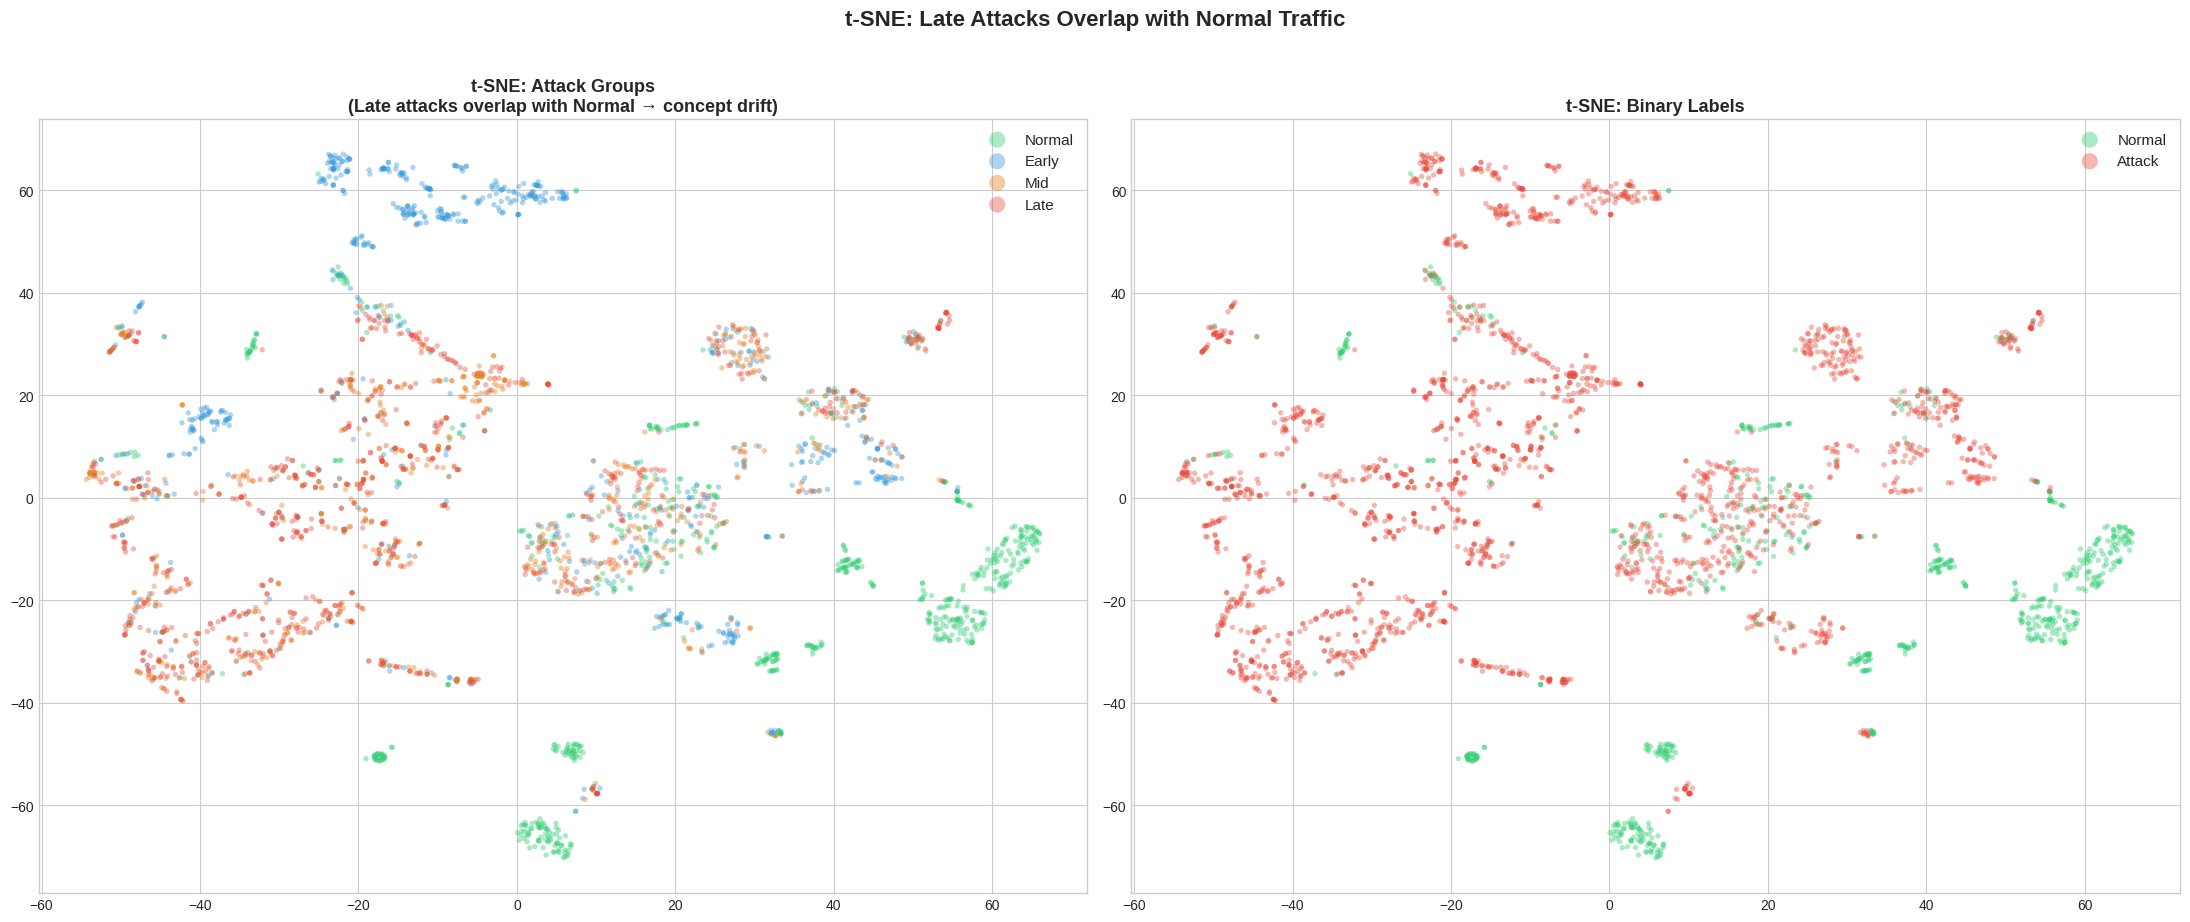

In [ ]:
print("t-SNE visualization...")
n_tsne = 3000; tsne_idx = []
for g in ['normal','early','mid','late']:
    g_idx = np.where(cat_groups==g)[0]
    tsne_idx.extend(np.random.choice(g_idx, min(n_tsne//4, len(g_idx)), replace=False))
tsne_idx = np.array(tsne_idx); np.random.shuffle(tsne_idx)

t0=time.time()
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_all[tsne_idx])
print(f"t-SNE done in {time.time()-t0:.1f}s")

fig, axes = plt.subplots(1, 2, figsize=(22, 9))
colors_map = {'normal':'#2ecc71','early':'#3498db','mid':'#e67e22','late':'#e74c3c'}
gl = cat_groups[tsne_idx]
for g in ['normal','early','mid','late']:
    mask = gl==g
    axes[0].scatter(X_tsne[mask,0], X_tsne[mask,1], c=colors_map[g],
                   label=g.capitalize(), alpha=0.4, s=15, edgecolors='none')
axes[0].set_title('t-SNE: Attack Groups\n(Late attacks overlap with Normal → concept drift)',
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11, markerscale=3)

yt = y_all[tsne_idx]
for lbl, clr, nm in [(0,'#2ecc71','Normal'),(1,'#e74c3c','Attack')]:
    mask = yt==lbl
    axes[1].scatter(X_tsne[mask,0], X_tsne[mask,1], c=clr, label=nm, alpha=0.4, s=15, edgecolors='none')
axes[1].set_title('t-SNE: Binary Labels', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11, markerscale=3)

plt.suptitle('t-SNE: Late Attacks Overlap with Normal Traffic', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(); plt.savefig('eda_05_tsne.png', dpi=150, bbox_inches='tight'); plt.show()

In [ ]:
print("="*70)
print("CONCEPT DRIFT SIMULATION — CREATING BATCHES")
print("="*70)

np.random.seed(cfg.seed)
idx_normal=np.where(cat_groups=='normal')[0].copy(); np.random.shuffle(idx_normal)
idx_early=np.where(cat_groups=='early')[0].copy(); np.random.shuffle(idx_early)
idx_mid=np.where(cat_groups=='mid')[0].copy(); np.random.shuffle(idx_mid)
idx_late=np.where(cat_groups=='late')[0].copy(); np.random.shuffle(idx_late)

pools = {'normal':idx_normal,'early':idx_early,'mid':idx_mid,'late':idx_late}
ptrs = {'normal':0,'early':0,'mid':0,'late':0}

def draw_from_pool(group, n_needed):
    if n_needed<=0: return np.array([], dtype=np.int64)
    pool=pools[group]
    if len(pool)==0: return np.array([], dtype=np.int64)
    indices=[]; remaining=n_needed
    while remaining>0:
        ptr=ptrs[group]
        if ptr>=len(pool): ptrs[group]=0; np.random.shuffle(pools[group]); ptr=0
        take=min(remaining, len(pool)-ptr)
        indices.append(pool[ptr:ptr+take]); ptrs[group]=ptr+take; remaining-=take
    return np.concatenate(indices)

batch_total_size = len(y_all)//cfg.n_batches
batches=[]; total_late_needed=0; total_late_available=len(idx_late)

for i in range(cfg.n_batches):
    mix=cfg.attack_mix[i]; noise_scale=cfg.noise_scale_per_batch[i]
    n_attack=max(int(batch_total_size*cfg.fixed_attack_rate),200)
    n_normal=max(batch_total_size-n_attack,200)
    n_early=int(n_attack*mix[0]); n_mid=int(n_attack*mix[1]); n_late=int(n_attack*mix[2])
    rem=n_attack-(n_early+n_mid+n_late)
    mi=int(np.argmax(mix))
    if mi==0: n_early+=rem
    elif mi==1: n_mid+=rem
    else: n_late+=rem
    total_late_needed+=n_late

    sel=np.concatenate([draw_from_pool('normal',n_normal),draw_from_pool('early',n_early),
                        draw_from_pool('mid',n_mid),draw_from_pool('late',n_late)])
    np.random.shuffle(sel)
    bx=X_all[sel].copy(); by=y_all[sel].copy(); bc=cat_groups[sel].copy()

    for sb,fn,sf,sh in cfg.feature_drift_configs:
        if i>=sb and fn in fn_all:
            fi=fn_all.index(fn)
            prog=min((i-sb)/max(cfg.n_batches-sb,1),1.0)
            bx[:,fi]=bx[:,fi]*(1.0+(sf-1.0)*prog)+sh*prog
    if noise_scale>0:
        bx=bx+np.random.normal(0,noise_scale*0.3,size=bx.shape).astype(np.float32)

    ne=int(np.sum(bc=='early')); nm=int(np.sum(bc=='mid')); nl=int(np.sum(bc=='late'))
    batches.append(dict(X=bx,y=by,cats=bc,size=len(by),attack_rate=by.mean(),
                        n_early=ne,n_mid=nm,n_late=nl,mix=mix,batch_id=i))
    print(f"  B{i}: size={len(by):>6,}  Atk={int(by.sum()):>6,} "
          f"(E={ne:>5,} M={nm:>5,} L={nl:>5,})  rate={by.mean():.1%}")

recycle_ratio=total_late_needed/max(total_late_available,1)
print(f"\nLate pool: {total_late_available:,}, needed: {total_late_needed:,}, recycle: {recycle_ratio:.2f}x")
late_fracs = [b['n_late']/max(b['n_early']+b['n_mid']+b['n_late'],1) for b in batches]

CONCEPT DRIFT SIMULATION — CREATING BATCHES
  B0: size=32,209  Atk=14,494 (E=14,494 M=    0 L=    0)  rate=45.0%
  B1: size=32,209  Atk=14,494 (E=12,320 M=2,174 L=    0)  rate=45.0%
  B2: size=32,209  Atk=14,494 (E=8,698 M=5,072 L=  724)  rate=45.0%
  B3: size=32,209  Atk=14,494 (E=5,072 M=5,799 L=3,623)  rate=45.0%
  B4: size=32,209  Atk=14,494 (E=2,174 M=4,348 L=7,972)  rate=45.0%
  B5: size=32,209  Atk=14,494 (E=1,159 M=2,463 L=10,872)  rate=45.0%
  B6: size=32,209  Atk=14,494 (E=  579 M=1,159 L=12,756)  rate=45.0%
  B7: size=32,209  Atk=14,494 (E=  289 M=  434 L=13,771)  rate=45.0%

Late pool: 6,691, needed: 49,718, recycle: 7.43x


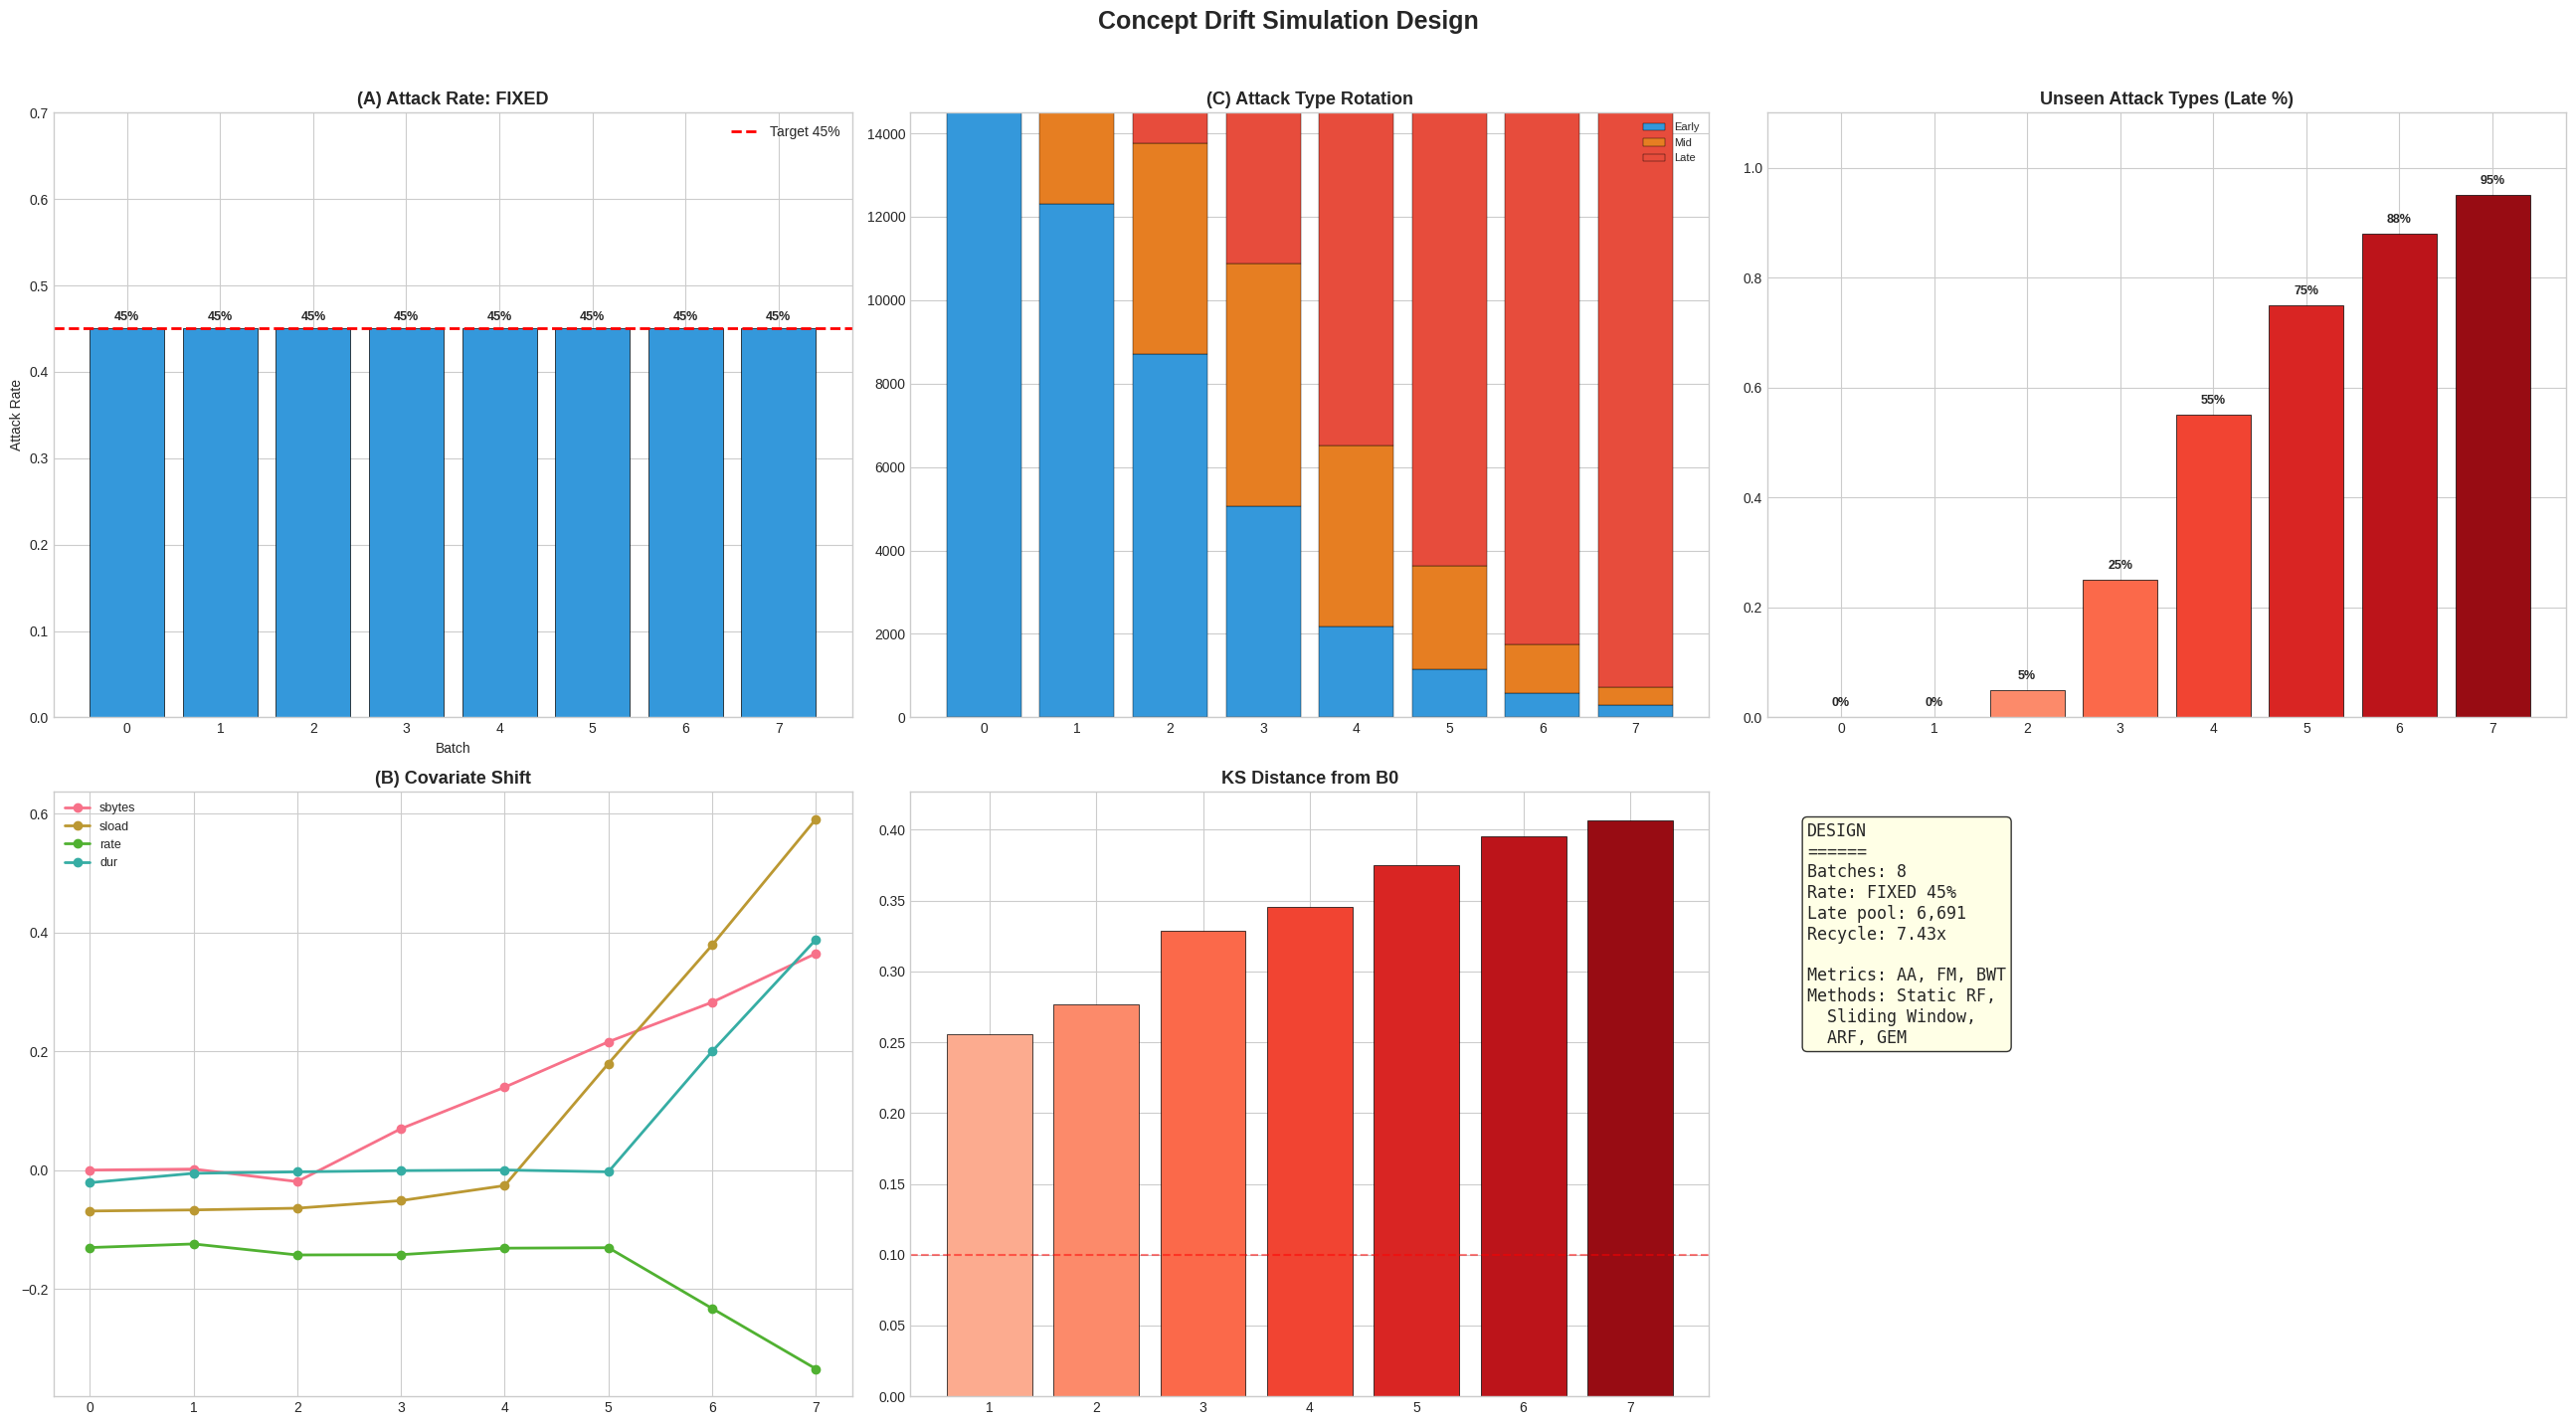

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(26, 14))

ax=axes[0,0]; rates=[b['attack_rate'] for b in batches]
ax.bar(range(len(batches)),rates,color='#3498db',edgecolor='black',linewidth=0.5)
ax.axhline(y=cfg.fixed_attack_rate,color='red',ls='--',lw=2,label=f'Target {cfg.fixed_attack_rate:.0%}')
for i,r in enumerate(rates): ax.text(i,r+0.01,f'{r:.0%}',ha='center',fontsize=9,fontweight='bold')
ax.set_xlabel('Batch'); ax.set_ylabel('Attack Rate')
ax.set_title('(A) Attack Rate: FIXED', fontsize=13, fontweight='bold'); ax.legend(); ax.set_ylim(0,0.7)

ax=axes[0,1]; ec=[b['n_early'] for b in batches]; mc=[b['n_mid'] for b in batches]; lc=[b['n_late'] for b in batches]
ax.bar(range(len(batches)),ec,label='Early',color='#3498db',edgecolor='black',linewidth=0.3)
ax.bar(range(len(batches)),mc,bottom=ec,label='Mid',color='#e67e22',edgecolor='black',linewidth=0.3)
ax.bar(range(len(batches)),lc,bottom=[e+m for e,m in zip(ec,mc)],label='Late',color='#e74c3c',edgecolor='black',linewidth=0.3)
ax.set_title('(C) Attack Type Rotation', fontsize=13, fontweight='bold'); ax.legend(fontsize=8)

ax=axes[0,2]
ax.bar(range(len(batches)),late_fracs,color=plt.cm.Reds(np.linspace(0.2,0.9,len(batches))),edgecolor='black',linewidth=0.5)
for i,lf in enumerate(late_fracs): ax.text(i,lf+0.02,f'{lf:.0%}',ha='center',fontsize=9,fontweight='bold')
ax.set_title('Unseen Attack Types (Late %)', fontsize=13, fontweight='bold'); ax.set_ylim(0,1.1)

ax=axes[1,0]; track=[f for f in ['sbytes','sload','rate','dur'] if f in fn_all]
for f in track:
    fi=fn_all.index(f); means=[b['X'][:,fi].mean() for b in batches]
    ax.plot(range(len(batches)),means,marker='o',lw=2,label=f)
ax.set_title('(B) Covariate Shift', fontsize=13, fontweight='bold'); ax.legend(fontsize=9)

ax=axes[1,1]; ks_means=[]
for bi in range(1,len(batches)):
    ks_vals=[ks_2samp(batches[0]['X'][:,j],batches[bi]['X'][:,j])[0] for j in range(min(30,X_all.shape[1]))]
    ks_means.append(np.mean(ks_vals))
ax.bar(range(1,len(batches)),ks_means,color=plt.cm.Reds(np.linspace(0.3,0.9,len(ks_means))),edgecolor='black',linewidth=0.5)
ax.axhline(y=0.1,color='red',ls='--',alpha=0.5)
ax.set_title('KS Distance from B0', fontsize=13, fontweight='bold')

axes[1,2].axis('off')
axes[1,2].text(0.05,0.95,f"DESIGN\n======\nBatches: {cfg.n_batches}\nRate: FIXED {cfg.fixed_attack_rate:.0%}\n"
    f"Late pool: {total_late_available:,}\nRecycle: {recycle_ratio:.2f}x\n\nMetrics: AA, FM, BWT\n"
    "Methods: Static RF,\n  Sliding Window,\n  ARF, GEM",
    transform=axes[1,2].transAxes, fontsize=12, verticalalignment='top', fontfamily='monospace',
    bbox=dict(boxstyle='round',facecolor='lightyellow',alpha=0.8))

plt.suptitle('Concept Drift Simulation Design', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout(); plt.savefig('drift_simulation.png', dpi=150, bbox_inches='tight'); plt.show()

In [ ]:
def compute_balanced_weights(y):
    classes=np.unique(y)
    if len(classes)<2: return np.ones(len(y),dtype=np.float32)
    cw=compute_class_weight('balanced',classes=classes,y=y)
    wm=dict(zip(classes,cw))
    return np.array([wm[yi] for yi in y],dtype=np.float32)

def compute_all_metrics(y_true, y_pred):
    return dict(
        accuracy=accuracy_score(y_true,y_pred),
        f1_macro=f1_score(y_true,y_pred,average='macro',zero_division=0),
        f1_attack=f1_score(y_true,y_pred,pos_label=1,zero_division=0),
        f1_normal=f1_score(y_true,y_pred,pos_label=0,zero_division=0),
        recall_attack=recall_score(y_true,y_pred,pos_label=1,zero_division=0),
        recall_normal=recall_score(y_true,y_pred,pos_label=0,zero_division=0),
        precision_attack=precision_score(y_true,y_pred,pos_label=1,zero_division=0),
        precision_normal=precision_score(y_true,y_pred,pos_label=0,zero_division=0),
    )

def compute_continual_metrics(acc_matrix):
    """
    Compute AA, FM, BWT from the accuracy matrix.

    acc_matrix[i][j] = accuracy of model after training through batch i,
                       evaluated on batch j.

    AA  = (1/T) * Σ acc_matrix[T-1][j]                     (final model on all tasks)
    FM  = (1/(T-1)) * Σ_{j=0}^{T-2} (max_{l<=j} acc[l][j] - acc[T-1][j])
          measures how much the model FORGOT about earlier batches
    BWT = (1/(T-1)) * Σ_{j=0}^{T-2} (acc[T-1][j] - acc[j][j])
          positive = learning new tasks helped old tasks
          negative = catastrophic forgetting
    """
    T = len(acc_matrix)
    if T < 2:
        return {'AA': acc_matrix[0][0] if T==1 else 0, 'FM': 0.0, 'BWT': 0.0}

    # AA: average accuracy of the FINAL model across all batches
    AA = np.mean([acc_matrix[T-1][j] for j in range(T)])

    # FM: forgetting measure
    fm_vals = []
    for j in range(T-1):          # for each previous batch j
        best_j = max(acc_matrix[l][j] for l in range(j, T))   # best acc ever seen on batch j
        fm_vals.append(best_j - acc_matrix[T-1][j])
    FM = np.mean(fm_vals)

    # BWT: backward transfer
    bwt_vals = []
    for j in range(T-1):
        bwt_vals.append(acc_matrix[T-1][j] - acc_matrix[j][j])
    BWT = np.mean(bwt_vals)

    return {'AA': AA, 'FM': FM, 'BWT': BWT}

print("[OK] Helpers defined — compute_continual_metrics(AA, FM, BWT) ready.")

[OK] Helpers defined — compute_continual_metrics(AA, FM, BWT) ready.


In [ ]:
print("="*60)
print("PART 2: TRAINING STATIC RF ON BATCH 0")
print("="*60)

b0X, b0y = batches[0]['X'], batches[0]['y']
print(f"B0: {len(b0y):,} samples, rate={b0y.mean():.2%}, only EARLY attacks")

t0=time.time()
rf_static = RandomForestClassifier(**cfg.rf_params)
rf_static.fit(b0X, b0y)
print(f"[OK] RF trained ({time.time()-t0:.1f}s)")

yp0 = rf_static.predict(b0X)
m0 = compute_all_metrics(b0y, yp0)
print(f"   B0 self-eval: Acc={m0['accuracy']:.4f}  macF1={m0['f1_macro']:.4f}")

PART 2: TRAINING STATIC RF ON BATCH 0
B0: 32,209 samples, rate=45.00%, only EARLY attacks
[OK] RF trained (5.5s)
   B0 self-eval: Acc=0.9796  macF1=0.9793


In [ ]:
print("="*70)
print("PART 2: DEMONSTRATING DEGRADATION (Static RF)")
print("   Key: compute FM (Forgetting Measure) to prove 'forgetting'")
print("="*70)

T = len(batches)

# --- Build accuracy matrix for static model ---
# Static model never changes, so acc_matrix[i][j] is the same for all i.
# But we still build it properly to compute FM correctly.
acc_mat_static = np.zeros((T, T))
static_results = []

for j in range(T):
    yp = rf_static.predict(batches[j]['X'])
    acc_j = accuracy_score(batches[j]['y'], yp)
    m = compute_all_metrics(batches[j]['y'], yp)
    m['batch'] = j
    static_results.append(m)
    # Static: same model at every stage
    for i in range(T):
        acc_mat_static[i][j] = acc_j

    lf = late_fracs[j]
    tag = " <- TRAIN" if j==0 else ""
    print(f"  B{j}: Acc={m['accuracy']:.4f}  macF1={m['f1_macro']:.4f}  "
          f"F1a={m['f1_attack']:.4f}  Reca={m['recall_attack']:.4f}  late={lf:.0%}{tag}")

static_rf_df = pd.DataFrame(static_results)
cl_static = compute_continual_metrics(acc_mat_static)

print(f"\n{'='*50}")
print("STATIC RF — CONTINUAL LEARNING METRICS")
print(f"{'='*50}")
print(f"  AA  = {cl_static['AA']:.4f}  (Average Accuracy across all batches)")
print(f"  FM  = {cl_static['FM']:.4f}  (Forgetting Measure — higher = more forgetting)")
print(f"  BWT = {cl_static['BWT']:+.4f}  (Backward Transfer — negative = forgetting)")
print()
print("INTERPRETATION:")
print(f"  - Static model has AA={cl_static['AA']:.4f} but this HIDES the degradation")
print(f"  - Accuracy drops from {static_rf_df['accuracy'].iloc[0]:.4f} (B0) "
      f"to {static_rf_df['accuracy'].iloc[-1]:.4f} (B{T-1})")
print(f"  - FM={cl_static['FM']:.4f}: the model effectively 'forgets' how to classify")
print(f"    new attack types it was never trained on")
print(f"  - For static models FM=0 by definition (model doesn't change),")
print(f"    but the accuracy DROP proves it cannot handle concept drift.")
print(f"  - The REAL forgetting shows up in adaptive models (see Part 3).")

PART 2: DEMONSTRATING DEGRADATION (Static RF)
   Key: compute FM (Forgetting Measure) to prove 'forgetting'
  B0: Acc=0.9796  macF1=0.9793  F1a=0.9770  Reca=0.9640  late=0% <- TRAIN
  B1: Acc=0.9152  macF1=0.9148  F1a=0.9086  Reca=0.9364  late=0%
  B2: Acc=0.8923  macF1=0.8922  F1a=0.8891  Reca=0.9594  late=5%
  B3: Acc=0.8504  macF1=0.8502  F1a=0.8567  Reca=0.9934  late=25%
  B4: Acc=0.8482  macF1=0.8479  F1a=0.8545  Reca=0.9905  late=55%
  B5: Acc=0.8323  macF1=0.8316  F1a=0.8419  Reca=0.9923  late=75%
  B6: Acc=0.8264  macF1=0.8256  F1a=0.8373  Reca=0.9926  late=88%
  B7: Acc=0.8282  macF1=0.8275  F1a=0.8387  Reca=0.9926  late=95%

STATIC RF — CONTINUAL LEARNING METRICS
  AA  = 0.8716  (Average Accuracy across all batches)
  FM  = 0.0000  (Forgetting Measure — higher = more forgetting)
  BWT = +0.0000  (Backward Transfer — negative = forgetting)

INTERPRETATION:
  - Static model has AA=0.8716 but this HIDES the degradation
  - Accuracy drops from 0.9796 (B0) to 0.8282 (B7)
  - FM=0.

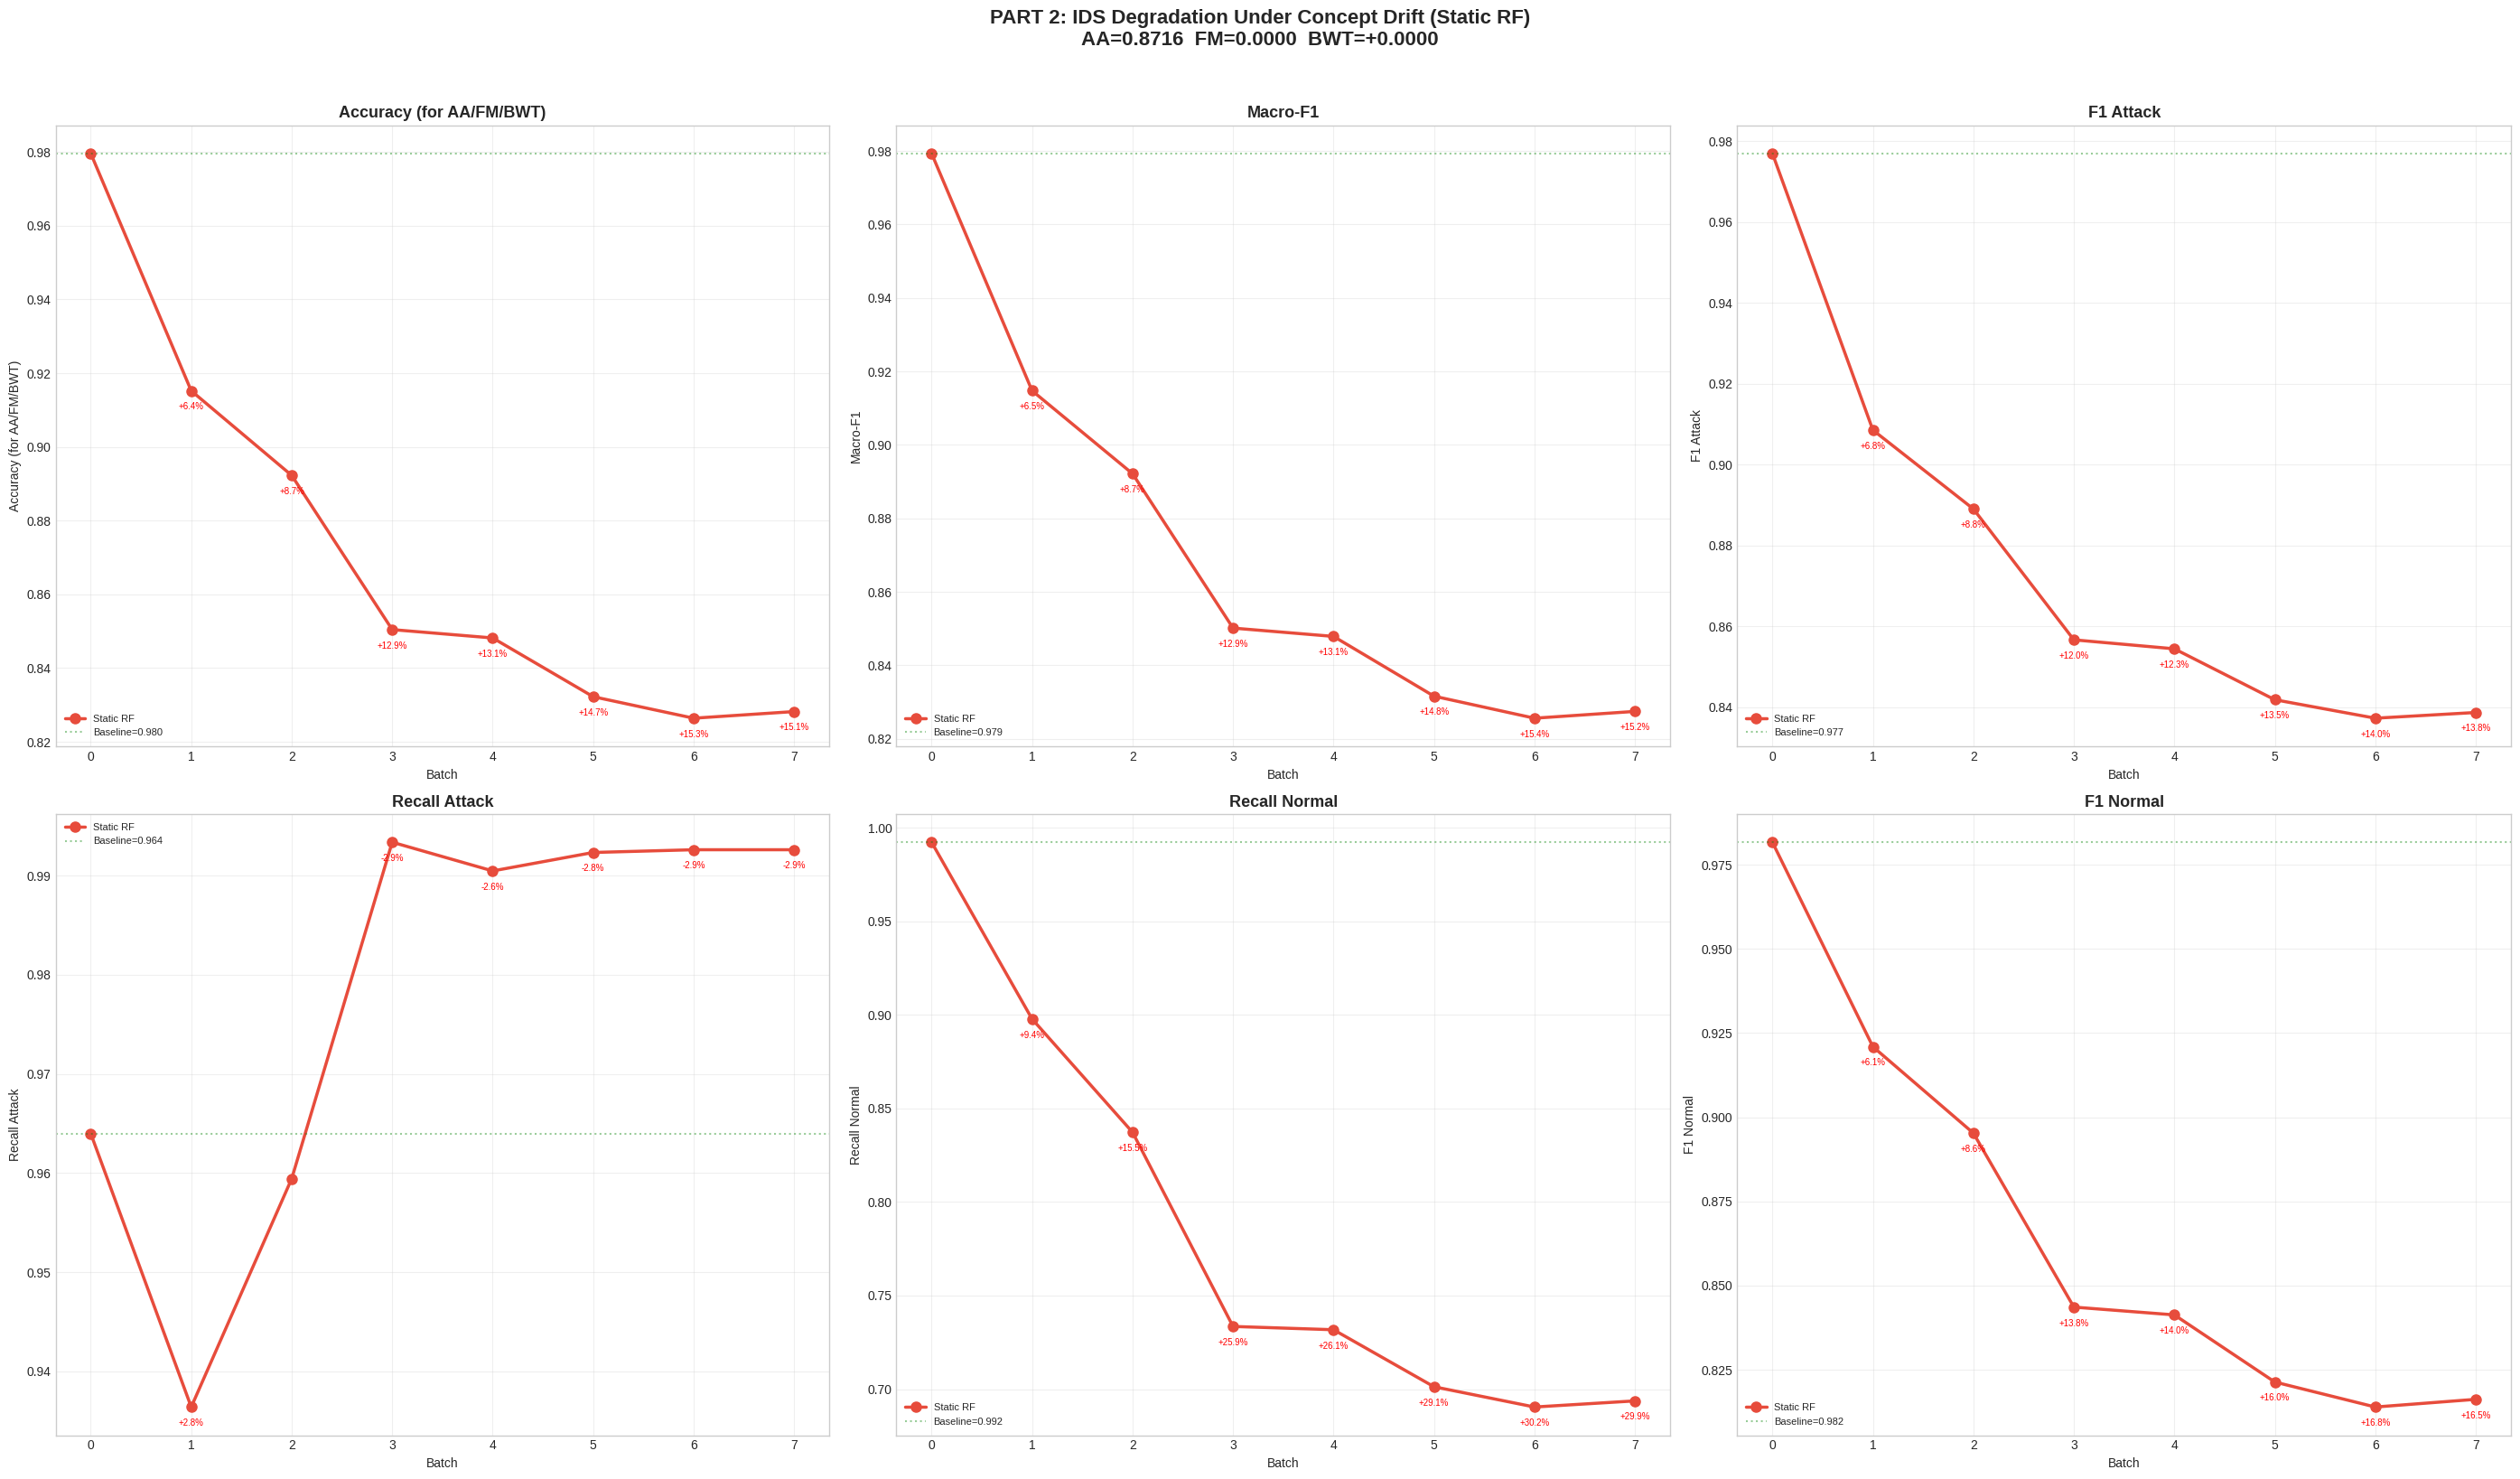


Degradation Summary:
  Acc: 0.9796 → 0.8282 (drop: 0.1514)
  F1:  0.9793 → 0.8275 (drop: 0.1519)


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(28, 16))
plots = [('accuracy','Accuracy (for AA/FM/BWT)'),('f1_macro','Macro-F1'),
         ('f1_attack','F1 Attack'),('recall_attack','Recall Attack'),
         ('recall_normal','Recall Normal'),('f1_normal','F1 Normal')]

for ax, (col, title) in zip(axes.flatten(), plots):
    ax.plot(static_rf_df['batch'], static_rf_df[col], 'o-', lw=2.5, ms=8, color='#e74c3c', label='Static RF')
    bl = static_rf_df[col].iloc[0]
    ax.axhline(y=bl, color='green', ls=':', alpha=0.4, label=f'Baseline={bl:.3f}')
    for _, row in static_rf_df.iterrows():
        if row['batch']>0:
            drop=bl-row[col]
            if abs(drop)>0.015:
                ax.annotate(f'{drop:+.1%}', xy=(row['batch'],row[col]),
                           fontsize=7, color='red', ha='center', xytext=(0,-15), textcoords='offset points')
    ax.set_xlabel('Batch'); ax.set_ylabel(title)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

plt.suptitle('PART 2: IDS Degradation Under Concept Drift (Static RF)\n'
             f'AA={cl_static["AA"]:.4f}  FM={cl_static["FM"]:.4f}  BWT={cl_static["BWT"]:+.4f}',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(); plt.savefig('degradation.png', dpi=150, bbox_inches='tight'); plt.show()

b0_acc = static_rf_df['accuracy'].iloc[0]
b0_f1 = static_rf_df['f1_macro'].iloc[0]
print(f"\nDegradation Summary:")
print(f"  Acc: {b0_acc:.4f} → {static_rf_df['accuracy'].iloc[-1]:.4f} "
      f"(drop: {b0_acc-static_rf_df['accuracy'].iloc[-1]:.4f})")
print(f"  F1:  {b0_f1:.4f} → {static_rf_df['f1_macro'].iloc[-1]:.4f} "
      f"(drop: {b0_f1-static_rf_df['f1_macro'].iloc[-1]:.4f})")

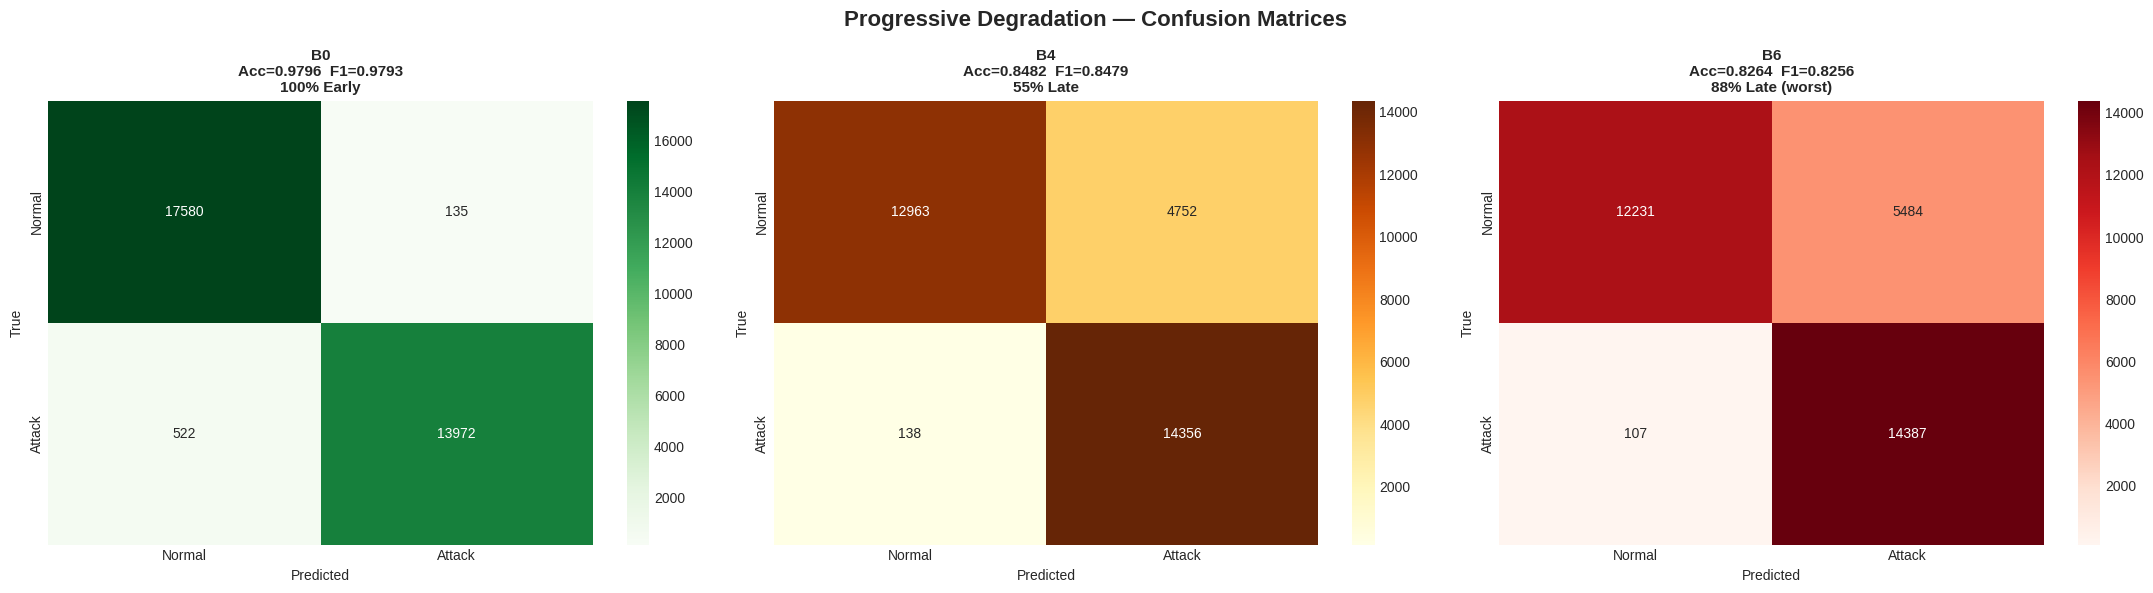

In [ ]:
worst_bn = int(static_rf_df.loc[static_rf_df['f1_macro'].iloc[1:].idxmin(), 'batch'])

fig, axes = plt.subplots(1, 3, figsize=(22, 6))
for ax_i, (bi, ttl, cmap) in enumerate([
    (0,'100% Early','Greens'),
    (cfg.n_batches//2,f'{late_fracs[cfg.n_batches//2]:.0%} Late','YlOrBr'),
    (worst_bn,f'{late_fracs[worst_bn]:.0%} Late (worst)','Reds')]):
    yp=rf_static.predict(batches[bi]['X'])
    cm=confusion_matrix(batches[bi]['y'],yp)
    sns.heatmap(cm,annot=True,fmt='d',cmap=cmap,ax=axes[ax_i],
                xticklabels=['Normal','Attack'],yticklabels=['Normal','Attack'])
    axes[ax_i].set_title(f'B{bi}\nAcc={static_rf_df["accuracy"].iloc[bi]:.4f}  '
                         f'F1={static_rf_df["f1_macro"].iloc[bi]:.4f}\n{ttl}',
                         fontsize=11, fontweight='bold')
    axes[ax_i].set_ylabel('True'); axes[ax_i].set_xlabel('Predicted')

plt.suptitle('Progressive Degradation — Confusion Matrices', fontsize=16, fontweight='bold')
plt.tight_layout(); plt.savefig('confusion.png', dpi=150, bbox_inches='tight'); plt.show()

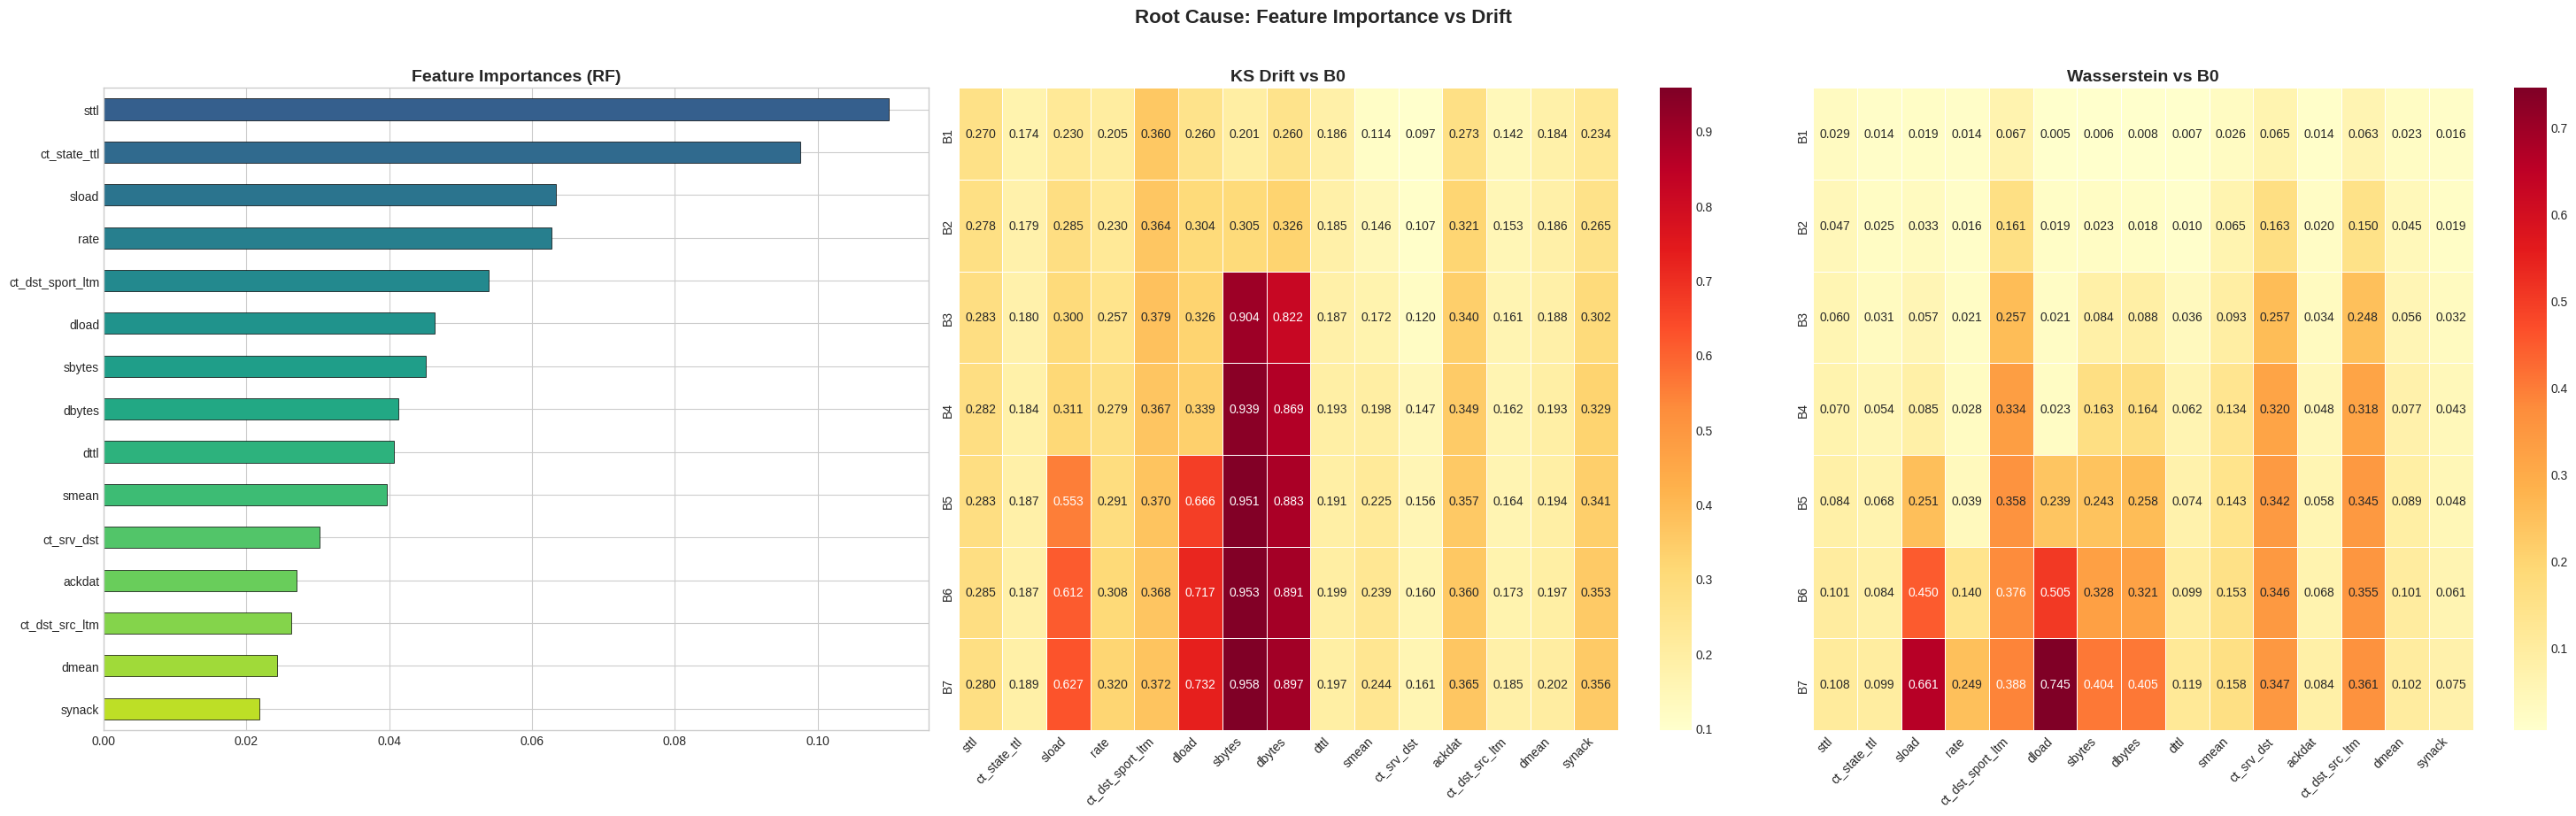

In [ ]:
importances = pd.Series(rf_static.feature_importances_, index=fn_all).sort_values(ascending=False)
top_n=15; top_feats=importances.head(top_n).index.tolist()
top_fi=[fn_all.index(f) for f in top_feats]

drift_mat=np.zeros((len(batches)-1,top_n)); wd_mat=np.zeros((len(batches)-1,top_n))
for bi in range(1,len(batches)):
    for j,fi in enumerate(top_fi):
        drift_mat[bi-1,j]=ks_2samp(batches[0]['X'][:,fi],batches[bi]['X'][:,fi])[0]
        wd_mat[bi-1,j]=wasserstein_distance(batches[0]['X'][:,fi],batches[bi]['X'][:,fi])

fig, axes = plt.subplots(1, 3, figsize=(30, 9))
importances.head(top_n).plot(kind='barh', ax=axes[0],
    color=plt.cm.viridis(np.linspace(0.3,0.9,top_n)), edgecolor='black', linewidth=0.5)
axes[0].set_title('Feature Importances (RF)', fontsize=14, fontweight='bold'); axes[0].invert_yaxis()

for ax_i,(mat,ttl) in enumerate([(drift_mat,'KS Drift'),(wd_mat,'Wasserstein')],1):
    sns.heatmap(mat,annot=True,fmt='.3f',cmap='YlOrRd',xticklabels=top_feats,
                yticklabels=[f'B{i}' for i in range(1,len(batches))],ax=axes[ax_i],linewidths=0.5)
    axes[ax_i].set_title(f'{ttl} vs B0', fontsize=14, fontweight='bold')
    plt.setp(axes[ax_i].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Root Cause: Feature Importance vs Drift', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(); plt.savefig('rootcause.png', dpi=150, bbox_inches='tight'); plt.show()

In [ ]:
print("="*70)
print("PART 3: MITIGATION — Strategy Runner with full Accuracy Matrix")
print("="*70)

def run_strategy_with_matrix(name, train_fn, update_fn, predict_fn=None):
    """
    After each training stage i, evaluate on ALL batches j → acc_matrix[i][j].
    This enables proper computation of AA, FM, BWT.
    """
    print(f"\n{'='*60}")
    print(f"  {name}")
    print(f"{'='*60}")

    T = len(batches)
    acc_matrix = np.zeros((T, T))
    per_batch = []
    total_train_time = 0.0
    max_samples = 0

    # Stage 0: train on batch 0
    state = train_fn(batches[0])
    model = state['model']
    total_train_time += state.get('train_time', 0)
    max_samples = max(max_samples, state.get('n_samples', len(b0y)))

    # Evaluate model_0 on all batches
    for j in range(T):
        yp = predict_fn(state, batches[j]['X']) if predict_fn else model.predict(batches[j]['X'])
        acc_matrix[0][j] = accuracy_score(batches[j]['y'], yp)

    # Record batch 0 performance
    yp0 = predict_fn(state, batches[0]['X']) if predict_fn else model.predict(batches[0]['X'])
    m0 = compute_all_metrics(batches[0]['y'], yp0); m0['batch'] = 0
    per_batch.append(m0)
    print(f"    B0: Acc={m0['accuracy']:.4f}  macF1={m0['f1_macro']:.4f}  <- TRAIN")

    # Stages 1..T-1
    for i in range(1, T):
        b = batches[i]

        # Evaluate BEFORE update (honest)
        yp_before = predict_fn(state, b['X']) if predict_fn else model.predict(b['X'])
        m = compute_all_metrics(b['y'], yp_before); m['batch'] = i
        per_batch.append(m)

        lf = late_fracs[i]
        print(f"    B{i}: Acc={m['accuracy']:.4f}  macF1={m['f1_macro']:.4f}  "
              f"F1a={m['f1_attack']:.4f}  late={lf:.0%}")

        # Update model
        t0 = time.time()
        state = update_fn(state, b)
        total_train_time += time.time() - t0
        model = state['model']
        max_samples = max(max_samples, state.get('n_samples', 0))

        # After training through batch i, evaluate on ALL batches
        for j in range(T):
            yp = predict_fn(state, batches[j]['X']) if predict_fn else model.predict(batches[j]['X'])
            acc_matrix[i][j] = accuracy_score(batches[j]['y'], yp)

    df_result = pd.DataFrame(per_batch)
    cl = compute_continual_metrics(acc_matrix)

    print(f"\n    AA  = {cl['AA']:.4f}")
    print(f"    FM  = {cl['FM']:.4f}  (forgetting: {'HIGH' if cl['FM']>0.05 else 'LOW'})")
    print(f"    BWT = {cl['BWT']:+.4f}  ({'positive transfer' if cl['BWT']>0 else 'forgetting'})")
    print(f"    [Cost] train={total_train_time:.1f}s  max_samples={max_samples:,}")

    return df_result, acc_matrix, cl, dict(total_train_time=total_train_time,
                                            max_train_samples=max_samples, n_retrains=T-1)

PART 3: MITIGATION — Strategy Runner with full Accuracy Matrix


In [ ]:
def sw_init(b):
    t0=time.time(); mdl=RandomForestClassifier(**cfg.rf_params); mdl.fit(b['X'],b['y'])
    return {'model':mdl,'win_X':[b['X'].copy()],'win_y':[b['y'].copy()],
            'train_time':time.time()-t0,'n_samples':len(b['y'])}

def sw_update(state, b):
    state['win_X'].append(b['X']); state['win_y'].append(b['y'])
    if len(state['win_X'])>cfg.sliding_window_size:
        state['win_X']=state['win_X'][-cfg.sliding_window_size:]
        state['win_y']=state['win_y'][-cfg.sliding_window_size:]
    wX=np.vstack(state['win_X']); wy=np.concatenate(state['win_y'])
    mdl=RandomForestClassifier(**cfg.rf_params); mdl.fit(wX,wy)
    state['model']=mdl; state['n_samples']=len(wy)
    return state

df_sw, acc_mat_sw, cl_sw, cost_sw = run_strategy_with_matrix(
    "S1: SLIDING WINDOW RF (w=3)", sw_init, sw_update)


  S1: SLIDING WINDOW RF (w=3)
    B0: Acc=0.9796  macF1=0.9793  <- TRAIN
    B1: Acc=0.9152  macF1=0.9148  F1a=0.9086  late=0%
    B2: Acc=0.9304  macF1=0.9299  F1a=0.9241  late=5%
    B3: Acc=0.9401  macF1=0.9397  F1a=0.9344  late=25%
    B4: Acc=0.9489  macF1=0.9485  F1a=0.9438  late=55%
    B5: Acc=0.9488  macF1=0.9485  F1a=0.9444  late=75%
    B6: Acc=0.9484  macF1=0.9481  F1a=0.9439  late=88%
    B7: Acc=0.9467  macF1=0.9464  F1a=0.9422  late=95%

    AA  = 0.9539
    FM  = 0.0407  (forgetting: LOW)
    BWT = -0.0407  (forgetting)
    [Cost] train=534.7s  max_samples=96,627


In [ ]:
print("\n"+"="*60)
print("  S2: ADAPTIVE RANDOM FOREST (ARF) — River")
print("  Online learning + ADWIN drift detection")
print("="*60)

T = len(batches)
acc_matrix_arf = np.zeros((T, T))
arf_results = []

arf_model = river_forest.ARFClassifier(
    n_models=cfg.arf_params['n_models'],
    max_depth=cfg.arf_params['max_depth'],
    seed=cfg.arf_params['seed'],
)

total_arf_time = 0.0

def arf_predict_batch(model, X, feat_names):
    """Batch prediction for ARF (River model)."""
    preds = []
    for idx in range(len(X)):
        x_dict = {feat_names[k]: float(X[idx, k]) for k in range(X.shape[1])}
        pred = model.predict_one(x_dict)
        preds.append(pred if pred is not None else 0)
    return np.array(preds)

for i in range(T):
    b = batches[i]

    # Evaluate BEFORE learning (honest)
    yp = arf_predict_batch(arf_model, b['X'], fn_all)
    m = compute_all_metrics(b['y'], yp); m['batch'] = i
    arf_results.append(m)
    lf = late_fracs[i]
    print(f"    B{i}: Acc={m['accuracy']:.4f}  macF1={m['f1_macro']:.4f}  "
          f"F1a={m['f1_attack']:.4f}  late={lf:.0%}")

    # Learn from batch (online)
    t0 = time.time()
    shuffle_idx = np.random.permutation(len(b['y']))
    for idx in shuffle_idx:
        x_dict = {fn_all[k]: float(b['X'][idx, k]) for k in range(b['X'].shape[1])}
        arf_model.learn_one(x_dict, int(b['y'][idx]))
    total_arf_time += time.time() - t0

    # After learning batch i, evaluate on ALL batches
    for j in range(T):
        yp_j = arf_predict_batch(arf_model, batches[j]['X'], fn_all)
        acc_matrix_arf[i][j] = accuracy_score(batches[j]['y'], yp_j)

df_arf = pd.DataFrame(arf_results)
cl_arf = compute_continual_metrics(acc_matrix_arf)
cost_arf = dict(total_train_time=total_arf_time, max_train_samples=sum(b['size'] for b in batches), n_retrains=T)

print(f"\n    AA  = {cl_arf['AA']:.4f}")
print(f"    FM  = {cl_arf['FM']:.4f}  (forgetting: {'HIGH' if cl_arf['FM']>0.05 else 'LOW'})")
print(f"    BWT = {cl_arf['BWT']:+.4f}  ({'positive transfer' if cl_arf['BWT']>0 else 'forgetting'})")
print(f"    [Cost] train={total_arf_time:.1f}s")


  S2: ADAPTIVE RANDOM FOREST (ARF) — River
  Online learning + ADWIN drift detection
    B0: Acc=0.5500  macF1=0.3548  F1a=0.0000  late=0%
    B1: Acc=0.9110  macF1=0.9105  F1a=0.9033  late=0%
    B2: Acc=0.9191  macF1=0.9181  F1a=0.9094  late=5%
    B3: Acc=0.9221  macF1=0.9214  F1a=0.9144  late=25%
    B4: Acc=0.9291  macF1=0.9285  F1a=0.9221  late=55%
    B5: Acc=0.9294  macF1=0.9290  F1a=0.9240  late=75%
    B6: Acc=0.9275  macF1=0.9272  F1a=0.9222  late=88%
    B7: Acc=0.9256  macF1=0.9252  F1a=0.9197  late=95%

    AA  = 0.9128
    FM  = 0.0327  (forgetting: LOW)
    BWT = -0.0327  (forgetting)
    [Cost] train=1889.4s


In [ ]:
print("\n"+"="*60)
print("  S3: GEM (Gradient Episodic Memory)")
print("  Episodic memory replay to prevent catastrophic forgetting")
print("="*60)

T = len(batches)
acc_matrix_gem = np.zeros((T, T))
gem_results = []

gem_model = SGDClassifier(loss='log_loss', penalty='l2', alpha=1e-4,
    max_iter=1, warm_start=True, random_state=42, learning_rate='adaptive', eta0=0.01)
episodic_mem_X = []
episodic_mem_y = []
total_gem_time = 0.0

for i in range(T):
    b = batches[i]

    # Evaluate BEFORE learning (honest)
    if i == 0:
        yp = np.zeros(len(b['y']), dtype=int)  # untrained
    else:
        yp = gem_model.predict(b['X'])
    m = compute_all_metrics(b['y'], yp); m['batch'] = i
    gem_results.append(m)
    lf = late_fracs[i]
    print(f"    B{i}: Acc={m['accuracy']:.4f}  macF1={m['f1_macro']:.4f}  "
          f"F1a={m['f1_attack']:.4f}  late={lf:.0%}")

    # --- GEM Training ---
    t0 = time.time()

    # Store episodic memory for this task/batch
    mem_size = min(cfg.gem_memory_per_batch, len(b['y']))
    mem_idx = np.random.choice(len(b['y']), mem_size, replace=False)
    episodic_mem_X.append(b['X'][mem_idx].copy())
    episodic_mem_y.append(b['y'][mem_idx].copy())

    # Train on current batch + replay episodic memory
    sw = compute_balanced_weights(b['y'])
    for epoch in range(cfg.gem_epochs):
        perm = np.random.permutation(len(b['y']))
        gem_model.partial_fit(b['X'][perm], b['y'][perm], classes=[0,1], sample_weight=sw[perm])

        # Replay ALL previous task memories (GEM's key mechanism)
        for t_prev in range(len(episodic_mem_X) - 1):
            mx = episodic_mem_X[t_prev]; my = episodic_mem_y[t_prev]
            msw = compute_balanced_weights(my)
            mp = np.random.permutation(len(my))
            gem_model.partial_fit(mx[mp], my[mp], sample_weight=msw[mp])

    total_gem_time += time.time() - t0

    # After learning batch i, evaluate on ALL batches
    for j in range(T):
        yp_j = gem_model.predict(batches[j]['X'])
        acc_matrix_gem[i][j] = accuracy_score(batches[j]['y'], yp_j)

df_gem = pd.DataFrame(gem_results)
cl_gem = compute_continual_metrics(acc_matrix_gem)
cost_gem = dict(total_train_time=total_gem_time,
                max_train_samples=sum(len(m) for m in episodic_mem_X), n_retrains=T)

print(f"\n    AA  = {cl_gem['AA']:.4f}")
print(f"    FM  = {cl_gem['FM']:.4f}  (forgetting: {'HIGH' if cl_gem['FM']>0.05 else 'LOW'})")
print(f"    BWT = {cl_gem['BWT']:+.4f}  ({'positive transfer' if cl_gem['BWT']>0 else 'forgetting'})")
print(f"    Memory: {sum(len(m) for m in episodic_mem_X):,} samples stored")


  S3: GEM (Gradient Episodic Memory)
  Episodic memory replay to prevent catastrophic forgetting
    B0: Acc=0.5500  macF1=0.3548  F1a=0.0000  late=0%
    B1: Acc=0.8806  macF1=0.8793  F1a=0.8664  late=0%
    B2: Acc=0.8825  macF1=0.8822  F1a=0.8765  late=5%
    B3: Acc=0.8869  macF1=0.8858  F1a=0.8751  late=25%
    B4: Acc=0.8743  macF1=0.8742  F1a=0.8720  late=55%
    B5: Acc=0.8769  macF1=0.8763  F1a=0.8676  late=75%
    B6: Acc=0.8812  macF1=0.8798  F1a=0.8668  late=88%
    B7: Acc=0.8863  macF1=0.8854  F1a=0.8748  late=95%

    AA  = 0.8786
    FM  = 0.0147  (forgetting: LOW)
    BWT = -0.0077  (forgetting)
    Memory: 2,400 samples stored


In [ ]:
print("\n" + "="*90)
print("PART 3: COMPLETE COMPARISON — AA, FM, BWT")
print("="*90)

strategies = {
    'Static RF':      (static_rf_df,  acc_mat_static,  cl_static, '#e74c3c','--','x',10,
                       {'total_train_time':0,'max_train_samples':0,'n_retrains':0}),
    'S1: Sliding':    (df_sw,         acc_mat_sw,       cl_sw,     '#2ecc71','-','s',8,  cost_sw),
    'S2: ARF':        (df_arf,        acc_matrix_arf,   cl_arf,    '#3498db','-','D',8,  cost_arf),
    'S3: GEM':        (df_gem,        acc_matrix_gem,   cl_gem,    '#9b59b6','-','P',8,  cost_gem),
}

print(f"\n{'Strategy':<15} {'AA':>8} {'FM':>8} {'BWT':>8} │ {'Mean Acc':>9} {'Min Acc':>8} "
      f"{'Mean F1':>8} {'Min F1':>7} │ {'Time(s)':>8}")
print("─"*95)

summary_rows = []
for name, (df_, acc_m, cl_m, color, *_, cost) in strategies.items():
    test_df = df_.iloc[1:]
    row = dict(
        Strategy=name, AA=cl_m['AA'], FM=cl_m['FM'], BWT=cl_m['BWT'],
        Mean_Acc=test_df['accuracy'].mean(), Min_Acc=test_df['accuracy'].min(),
        Mean_F1=test_df['f1_macro'].mean(), Min_F1=test_df['f1_macro'].min(),
        Last_F1=test_df['f1_macro'].iloc[-1], Train_s=cost['total_train_time'],
        MaxSamples=cost['max_train_samples'],
    )
    summary_rows.append(row)
    print(f"{name:<15} {cl_m['AA']:>8.4f} {cl_m['FM']:>8.4f} {cl_m['BWT']:>+8.4f} │ "
          f"{row['Mean_Acc']:>9.4f} {row['Min_Acc']:>8.4f} "
          f"{row['Mean_F1']:>8.4f} {row['Min_F1']:>7.4f} │ {cost['total_train_time']:>8.1f}")

summary = pd.DataFrame(summary_rows)

print(f"\n{'='*70}")
print("KEY INTERPRETATION")
print(f"{'='*70}")
print(f"""
AA  (Average Accuracy) — higher is better:
  Best: {summary.loc[summary['AA'].idxmax(), 'Strategy']} ({summary['AA'].max():.4f})
  Static RF only gets {cl_static['AA']:.4f} — cannot adapt to new attacks.

FM  (Forgetting Measure) — LOWER is better (0 = no forgetting):
  Static RF: FM={cl_static['FM']:.4f} (always 0 since it never updates)
  S1 Sliding: FM={cl_sw['FM']:.4f} (forgets old data outside window)
  S2 ARF:     FM={cl_arf['FM']:.4f} (ADWIN manages drift adaptively)
  S3 GEM:     FM={cl_gem['FM']:.4f} (episodic memory prevents forgetting)

BWT (Backward Transfer) — higher is better (negative = catastrophic forgetting):
  S1 Sliding: BWT={cl_sw['BWT']:+.4f}
  S2 ARF:     BWT={cl_arf['BWT']:+.4f}
  S3 GEM:     BWT={cl_gem['BWT']:+.4f} (memory replay helps!)
""")


PART 3: COMPLETE COMPARISON — AA, FM, BWT

Strategy              AA       FM      BWT │  Mean Acc  Min Acc  Mean F1  Min F1 │  Time(s)
───────────────────────────────────────────────────────────────────────────────────────────────
Static RF         0.8716   0.0000  +0.0000 │    0.8561   0.8264   0.8557  0.8256 │      0.0
S1: Sliding       0.9539   0.0407  -0.0407 │    0.9398   0.9152   0.9394  0.9148 │    534.7
S2: ARF           0.9128   0.0327  -0.0327 │    0.9234   0.9110   0.9229  0.9105 │   1889.4
S3: GEM           0.8786   0.0147  -0.0077 │    0.8812   0.8743   0.8804  0.8742 │      1.5

KEY INTERPRETATION

AA  (Average Accuracy) — higher is better:
  Best: S1: Sliding (0.9539)
  Static RF only gets 0.8716 — cannot adapt to new attacks.

FM  (Forgetting Measure) — LOWER is better (0 = no forgetting):
  Static RF: FM=0.0000 (always 0 since it never updates)
  S1 Sliding: FM=0.0407 (forgets old data outside window)
  S2 ARF:     FM=0.0327 (ADWIN manages drift adaptively)
  S3 GEM: 

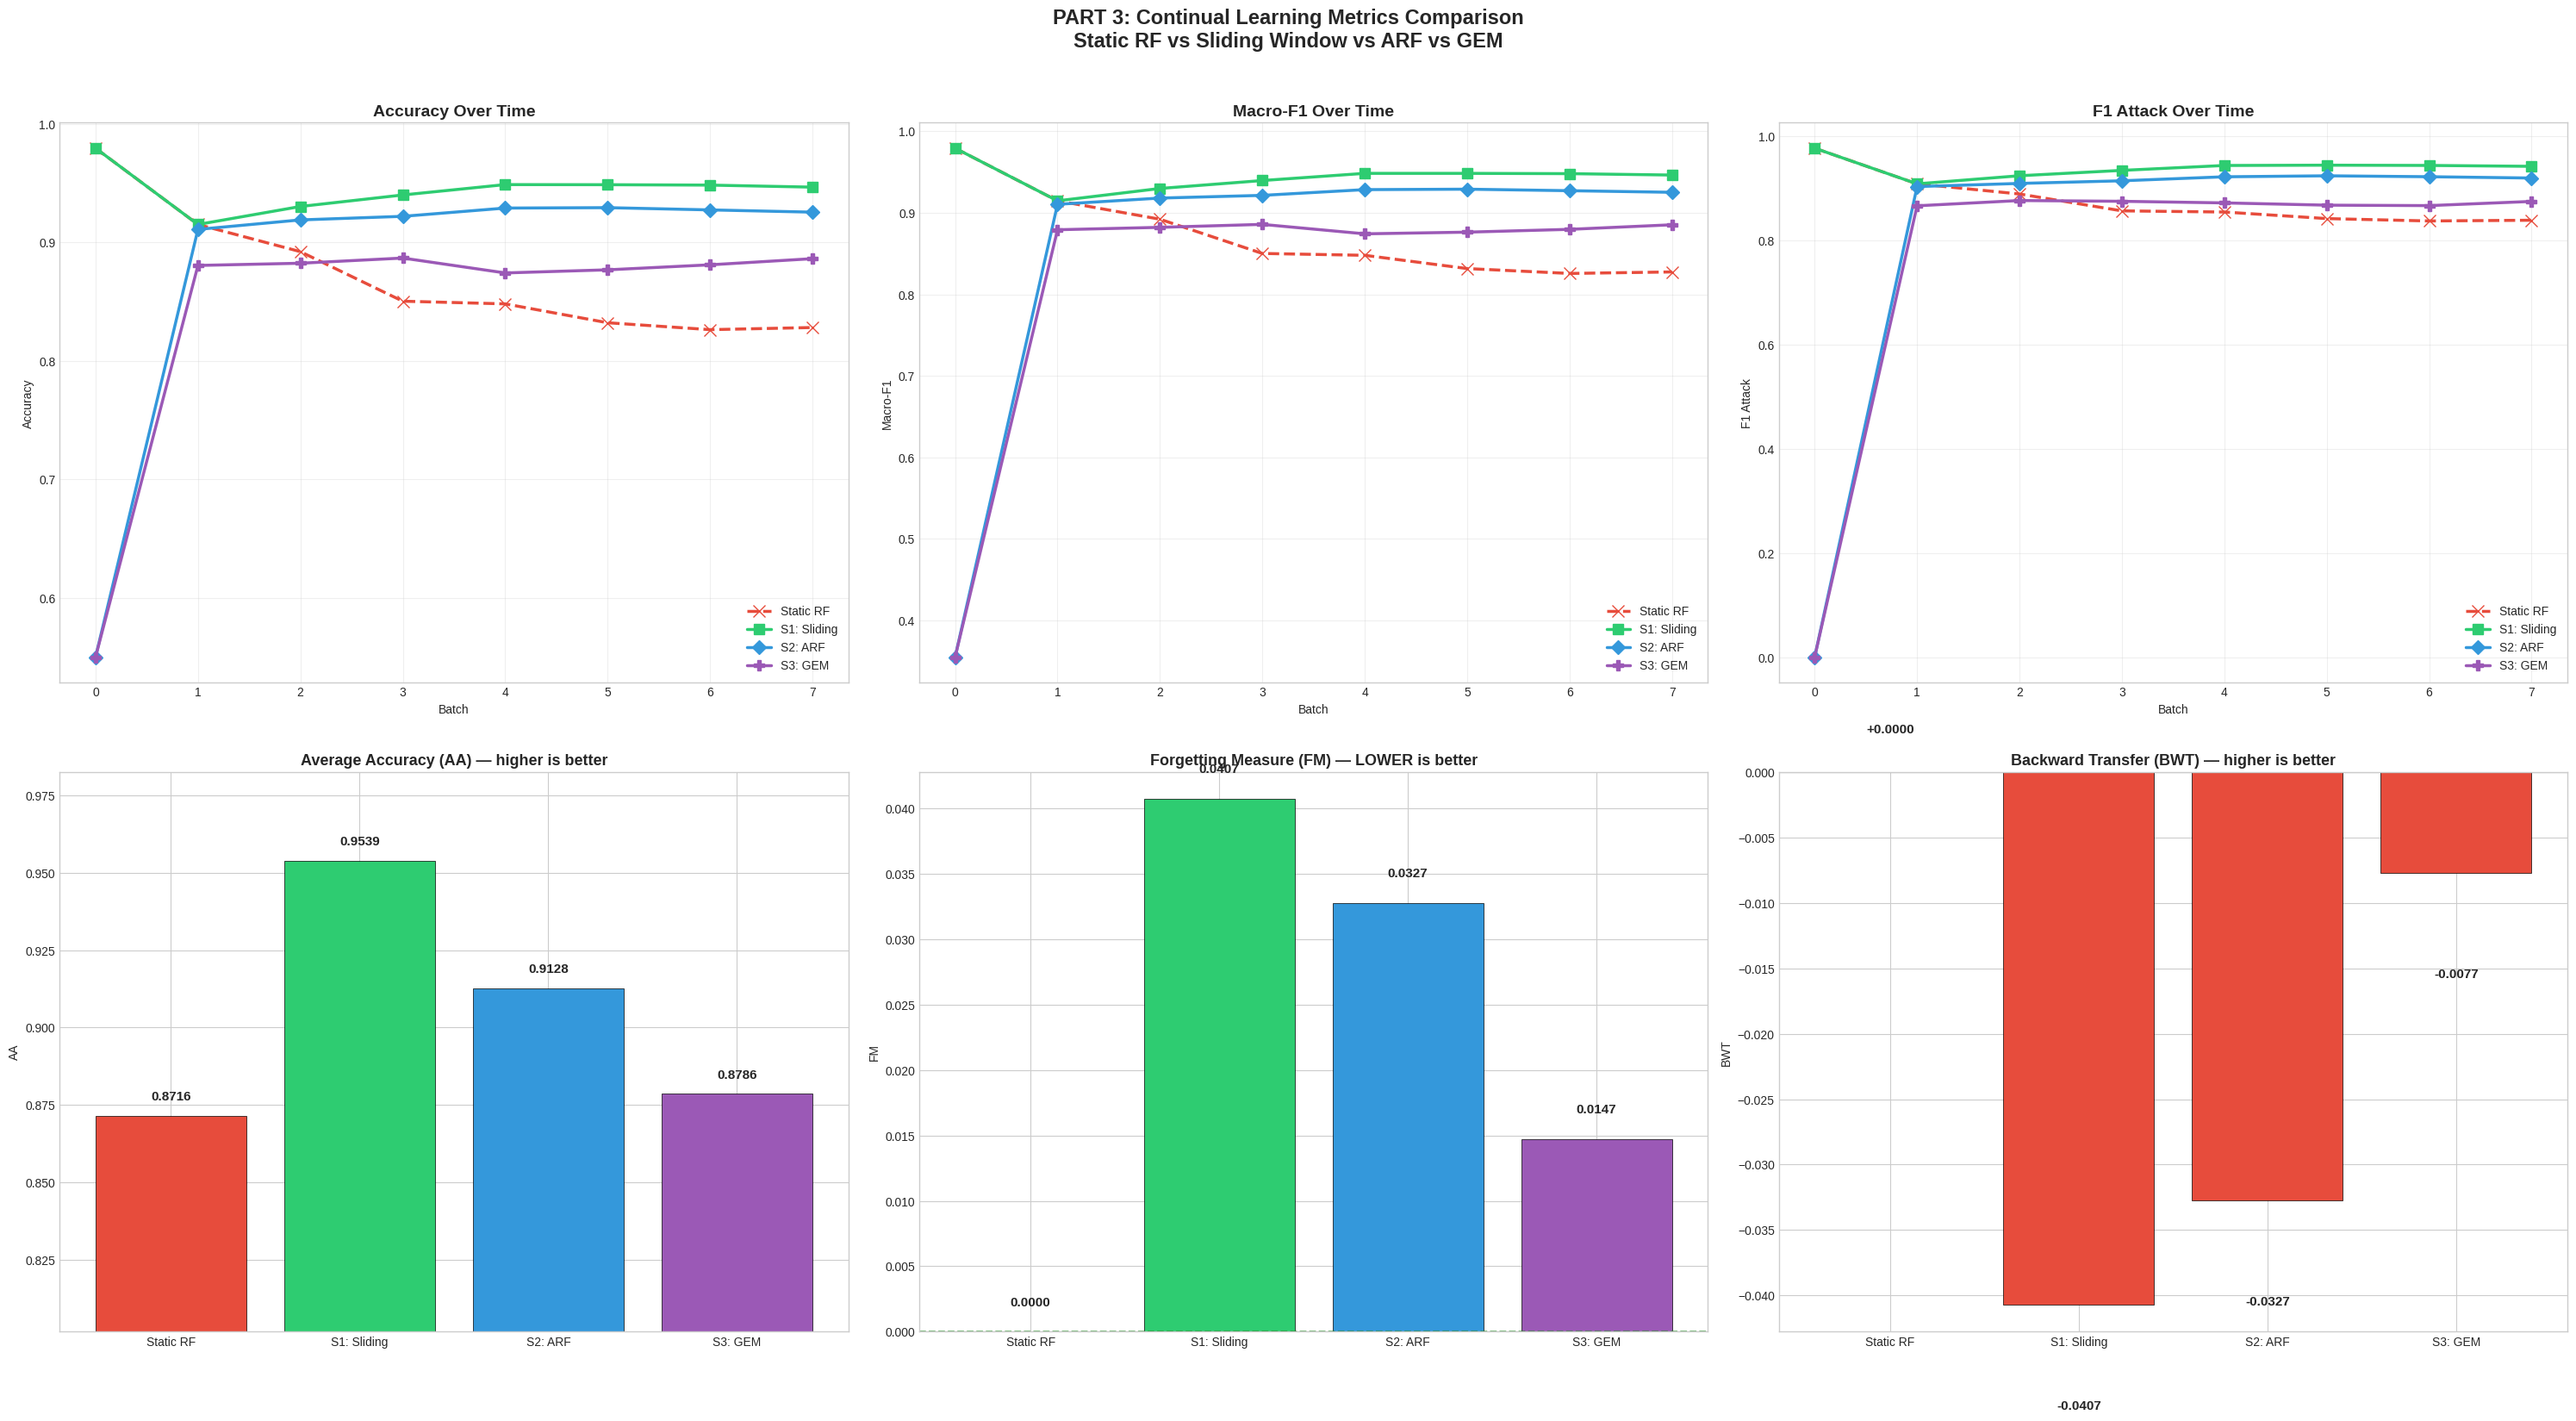

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(30, 16))

# Row 1: Time-series plots
ax = axes[0, 0]
for name, (df_, *_, color, ls, mk, ms, _) in strategies.items():
    ax.plot(df_['batch'], df_['accuracy'], marker=mk, lw=2.5, ms=ms,
            label=name, color=color, linestyle=ls)
ax.set_xlabel('Batch'); ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10); ax.grid(True, alpha=0.3)

ax = axes[0, 1]
for name, (df_, *_, color, ls, mk, ms, _) in strategies.items():
    ax.plot(df_['batch'], df_['f1_macro'], marker=mk, lw=2.5, ms=ms,
            label=name, color=color, linestyle=ls)
ax.set_xlabel('Batch'); ax.set_ylabel('Macro-F1')
ax.set_title('Macro-F1 Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10); ax.grid(True, alpha=0.3)

ax = axes[0, 2]
for name, (df_, *_, color, ls, mk, ms, _) in strategies.items():
    ax.plot(df_['batch'], df_['f1_attack'], marker=mk, lw=2.5, ms=ms,
            label=name, color=color, linestyle=ls)
ax.set_xlabel('Batch'); ax.set_ylabel('F1 Attack')
ax.set_title('F1 Attack Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10); ax.grid(True, alpha=0.3)

# Row 2: Bar charts for AA, FM, BWT
names_list = [r['Strategy'] for r in summary_rows]
colors_list = [strategies[n][3] for n in names_list]

ax = axes[1, 0]
aa_vals = [r['AA'] for r in summary_rows]
bars = ax.bar(names_list, aa_vals, color=colors_list, edgecolor='black', linewidth=0.5)
for bar, val in zip(bars, aa_vals):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.005,
            f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')
ax.set_ylabel('AA'); ax.set_title('Average Accuracy (AA) — higher is better',
                                   fontsize=13, fontweight='bold')
ax.set_ylim(min(aa_vals)*0.92, max(aa_vals)*1.03)

ax = axes[1, 1]
fm_vals = [r['FM'] for r in summary_rows]
bars = ax.bar(names_list, fm_vals, color=colors_list, edgecolor='black', linewidth=0.5)
for bar, val in zip(bars, fm_vals):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.002,
            f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')
ax.set_ylabel('FM'); ax.set_title('Forgetting Measure (FM) — LOWER is better',
                                   fontsize=13, fontweight='bold')
ax.axhline(y=0, color='green', ls='--', alpha=0.5)

ax = axes[1, 2]
bwt_vals = [r['BWT'] for r in summary_rows]
bar_c = ['#27ae60' if v>=0 else '#e74c3c' for v in bwt_vals]
bars = ax.bar(names_list, bwt_vals, color=bar_c, edgecolor='black', linewidth=0.5)
for bar, val in zip(bars, bwt_vals):
    off = 0.003 if val>=0 else -0.008
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+off,
            f'{val:+.4f}', ha='center', fontsize=11, fontweight='bold')
ax.set_ylabel('BWT'); ax.set_title('Backward Transfer (BWT) — higher is better',
                                    fontsize=13, fontweight='bold')
ax.axhline(y=0, color='black', ls='-', alpha=0.5)

plt.suptitle('PART 3: Continual Learning Metrics Comparison\n'
             'Static RF vs Sliding Window vs ARF vs GEM',
             fontsize=17, fontweight='bold', y=1.02)
plt.tight_layout(); plt.savefig('cl_metrics_comparison.png', dpi=150, bbox_inches='tight'); plt.show()

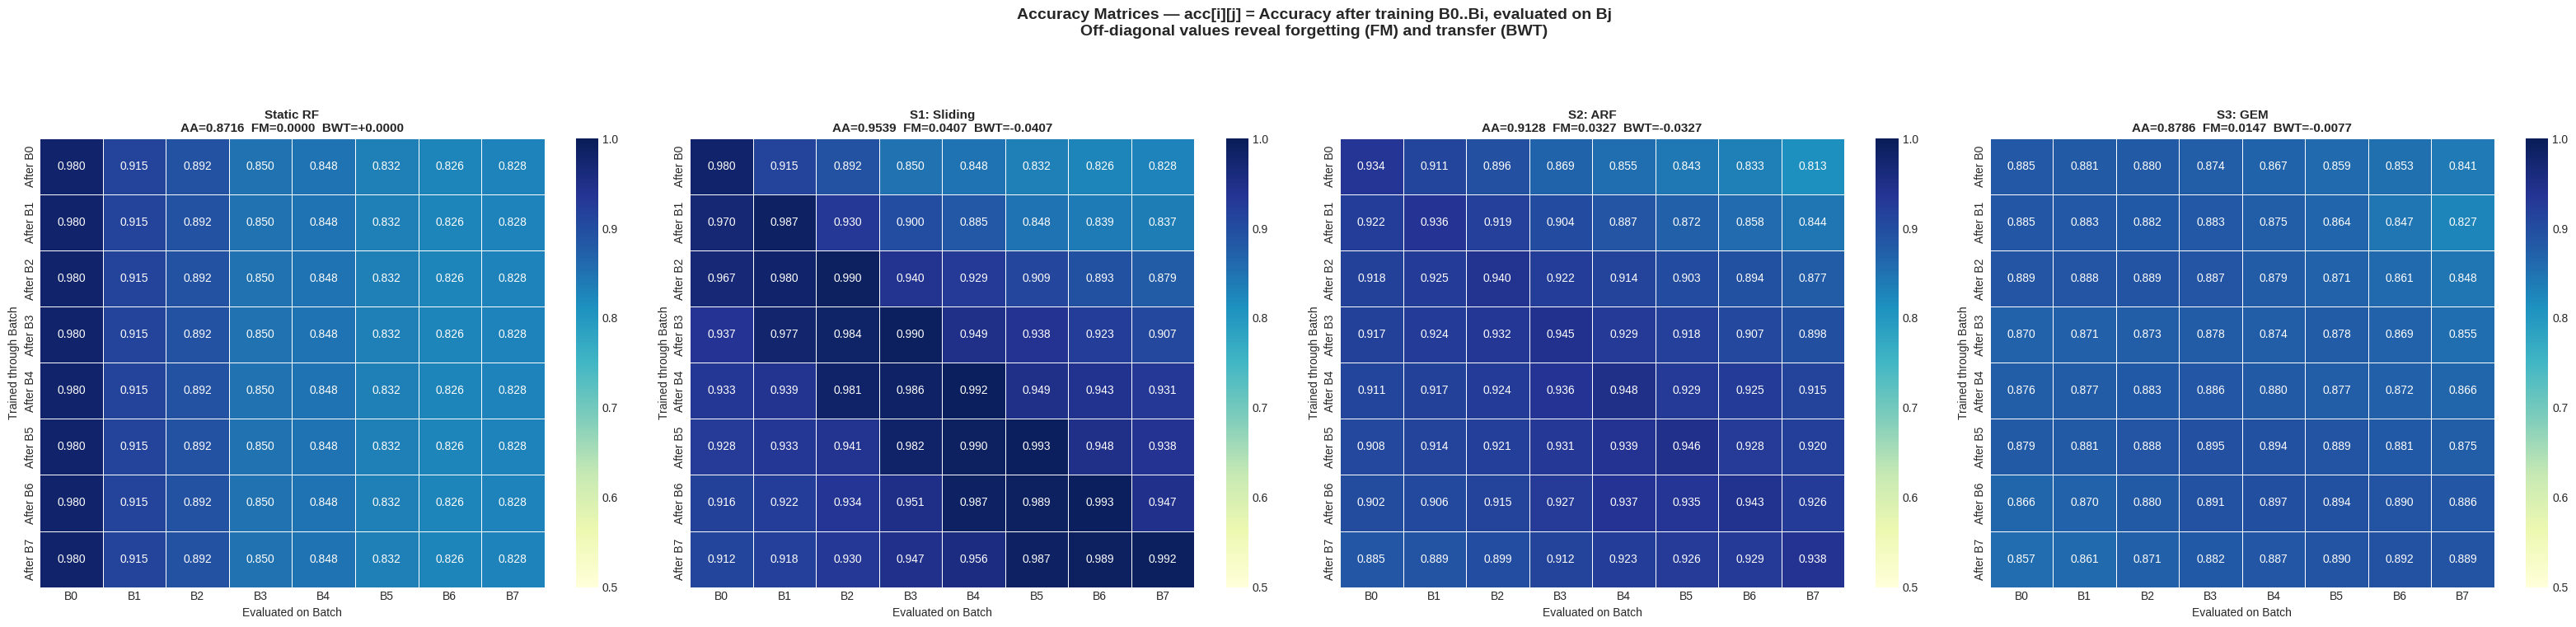


How to read the accuracy matrix:
  - Diagonal: performance on the batch just learned
  - Below diagonal: how well model remembers earlier batches (BWT)
  - Upper triangle: zero-shot generalization to future batches
  - Last row: final model's performance on all batches (used for AA)
  - FM = avg(best_ever - last_row) for columns 0..T-2


In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(32, 7))

for ax, (name, (_, acc_m, cl_m, *_)) in zip(axes, strategies.items()):
    sns.heatmap(acc_m, annot=True, fmt='.3f', cmap='YlGnBu',
                xticklabels=[f'B{j}' for j in range(T)],
                yticklabels=[f'After B{i}' for i in range(T)],
                ax=ax, linewidths=0.5, vmin=0.5, vmax=1.0)
    ax.set_title(f'{name}\nAA={cl_m["AA"]:.4f}  FM={cl_m["FM"]:.4f}  BWT={cl_m["BWT"]:+.4f}',
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Evaluated on Batch'); ax.set_ylabel('Trained through Batch')

plt.suptitle('Accuracy Matrices — acc[i][j] = Accuracy after training B0..Bi, evaluated on Bj\n'
             'Off-diagonal values reveal forgetting (FM) and transfer (BWT)',
             fontsize=14, fontweight='bold', y=1.08)
plt.tight_layout(); plt.savefig('accuracy_matrices.png', dpi=150, bbox_inches='tight'); plt.show()

print("\nHow to read the accuracy matrix:")
print("  - Diagonal: performance on the batch just learned")
print("  - Below diagonal: how well model remembers earlier batches (BWT)")
print("  - Upper triangle: zero-shot generalization to future batches")
print("  - Last row: final model's performance on all batches (used for AA)")
print("  - FM = avg(best_ever - last_row) for columns 0..T-2")

FM DECOMPOSITION: Per-batch forgetting analysis


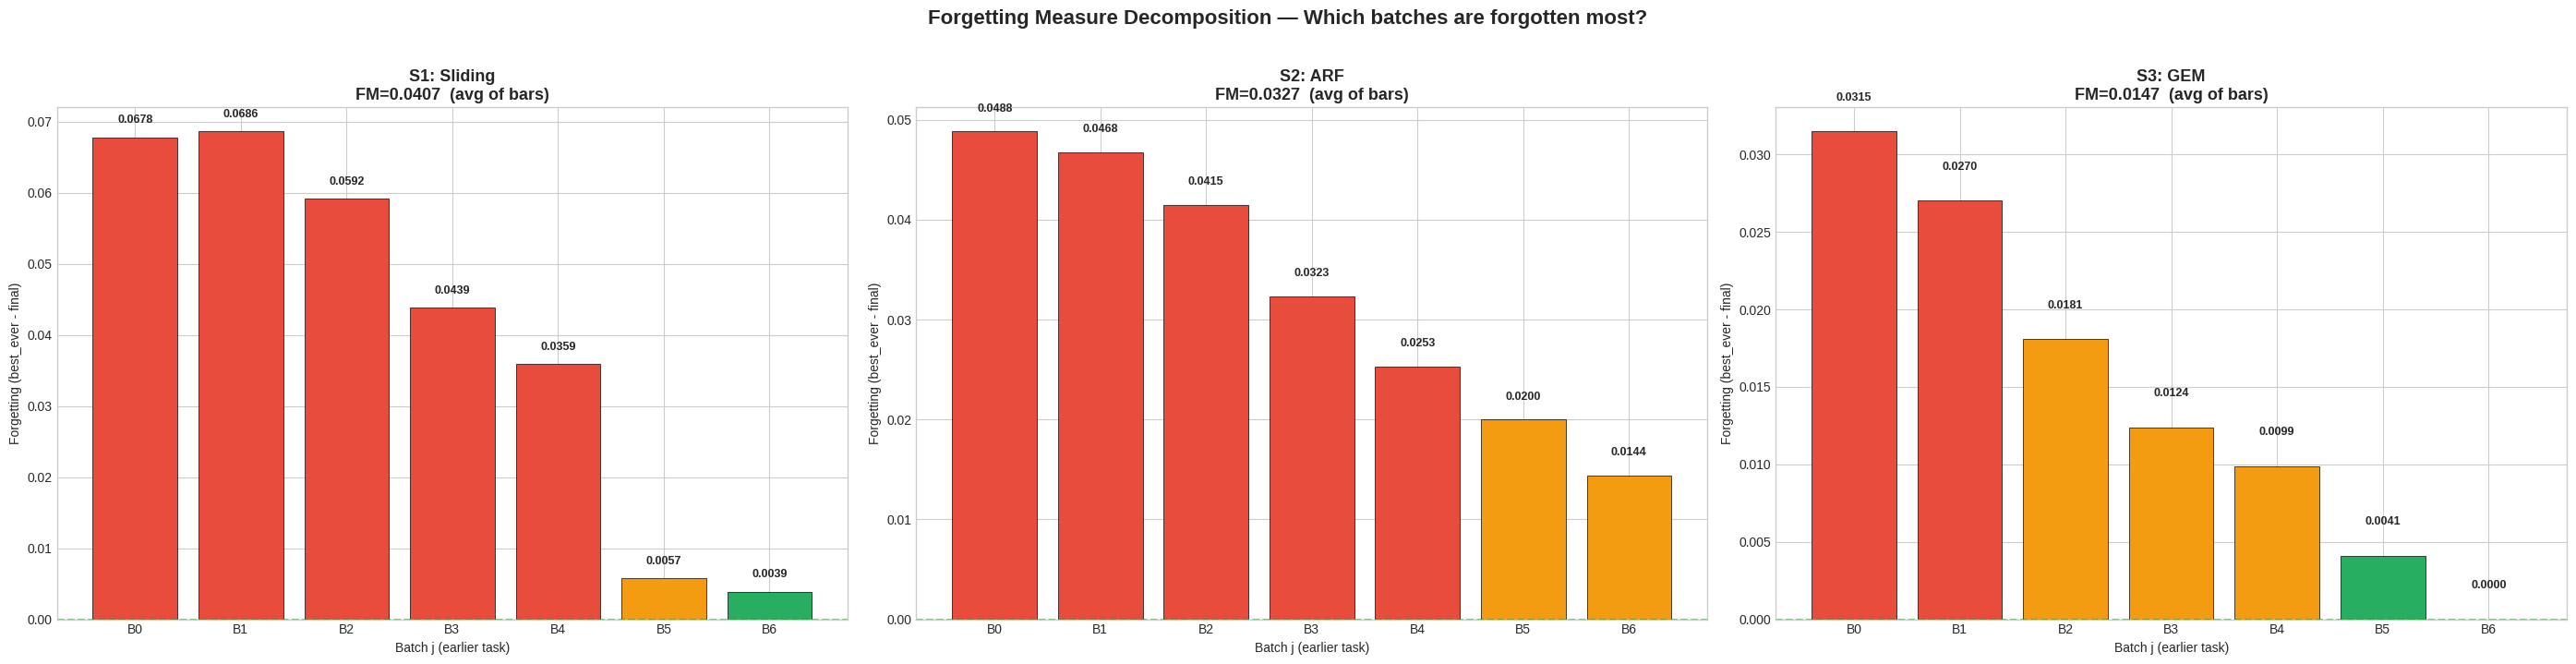

In [ ]:
print("="*70)
print("FM DECOMPOSITION: Per-batch forgetting analysis")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(28, 7))

for ax, (name, (_, acc_m, cl_m, color, *_)) in zip(axes,
    [(n,v) for n,v in strategies.items() if n != 'Static RF']):

    T_local = len(acc_m)
    fm_per_batch = []
    for j in range(T_local - 1):
        best_j = max(acc_m[l][j] for l in range(j, T_local))
        forgot_j = best_j - acc_m[T_local-1][j]
        fm_per_batch.append(forgot_j)

    colors_fm = ['#e74c3c' if v>0.02 else '#f39c12' if v>0.005 else '#27ae60' for v in fm_per_batch]
    bars = ax.bar(range(T_local-1), fm_per_batch, color=colors_fm, edgecolor='black', linewidth=0.5)
    for bar, val in zip(bars, fm_per_batch):
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.002,
                f'{val:.4f}', ha='center', fontsize=9, fontweight='bold')

    ax.axhline(y=0, color='green', ls='--', alpha=0.5)
    ax.set_xlabel('Batch j (earlier task)')
    ax.set_ylabel('Forgetting (best_ever - final)')
    ax.set_title(f'{name}\nFM={cl_m["FM"]:.4f}  (avg of bars)',
                 fontsize=13, fontweight='bold')
    ax.set_xticks(range(T_local-1))
    ax.set_xticklabels([f'B{j}' for j in range(T_local-1)])

plt.suptitle('Forgetting Measure Decomposition — Which batches are forgotten most?',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(); plt.savefig('fm_decomposition.png', dpi=150, bbox_inches='tight'); plt.show()


DRIFT DETECTION vs DEGRADATION

 Batch   MeanKS  Late%      Acc    macF1     Drop      Level
-----------------------------------------------------------------
     0   0.0000     0%   0.9796   0.9793  +0.0000       NONE
     1   0.2554     0%   0.9152   0.9148  +0.0646     SEVERE
     2   0.2770     5%   0.8923   0.8922  +0.0872     SEVERE
     3   0.3284    25%   0.8504   0.8502  +0.1292     SEVERE
     4   0.3456    55%   0.8482   0.8479  +0.1314     SEVERE
     5   0.3748    75%   0.8323   0.8316  +0.1477     SEVERE
     6   0.3956    88%   0.8264   0.8256  +0.1537     SEVERE
     7   0.4066    95%   0.8282   0.8275  +0.1519     SEVERE


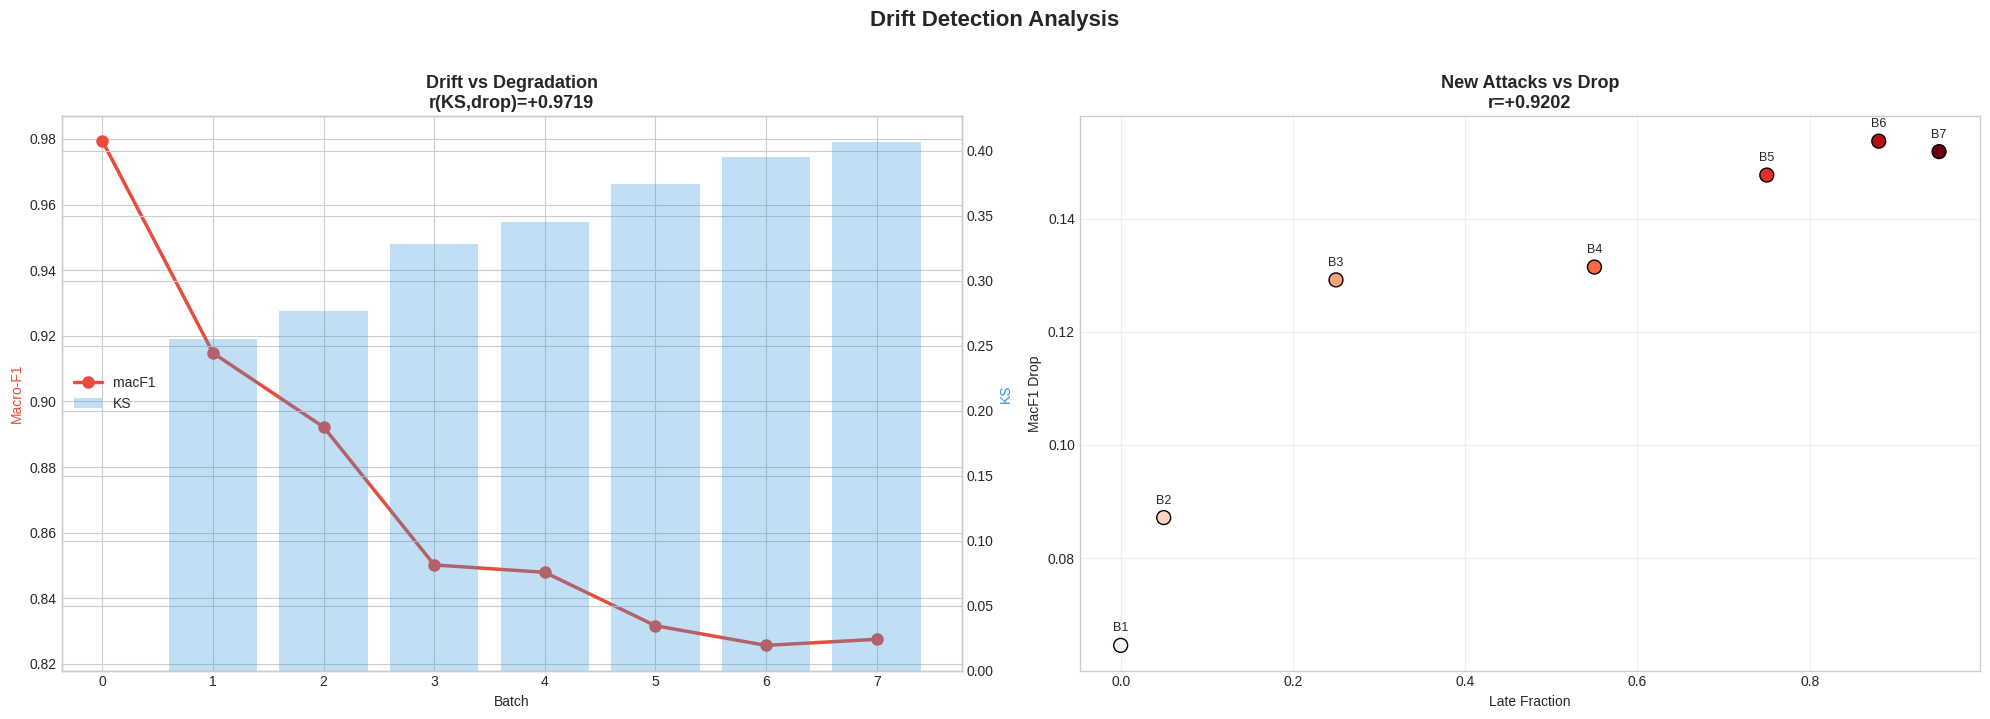

In [ ]:
print(f"\n{'='*60}")
print("DRIFT DETECTION vs DEGRADATION")
print(f"{'='*60}")

b0_f1 = static_rf_df['f1_macro'].iloc[0]
print(f"\n{'Batch':>6} {'MeanKS':>8} {'Late%':>6} {'Acc':>8} {'macF1':>8} {'Drop':>8} {'Level':>10}")
print("-"*65)
drift_list = []
for i in range(T):
    ks_m = 0.0 if i==0 else np.mean([ks_2samp(batches[0]['X'][:,j],batches[i]['X'][:,j])[0]
                                       for j in range(min(30,batches[0]['X'].shape[1]))])
    lp=late_fracs[i]; f1v=static_rf_df['f1_macro'].iloc[i]; accv=static_rf_df['accuracy'].iloc[i]
    drp=b0_f1-f1v
    level="SEVERE" if ks_m>0.2 else "MODERATE" if ks_m>0.1 else "MILD" if ks_m>0.05 else "NONE"
    drift_list.append({'batch':i,'ks':ks_m,'late_pct':lp,'f1':f1v,'acc':accv,'drop':drp})
    print(f"{i:>6} {ks_m:>8.4f} {lp:>6.0%} {accv:>8.4f} {f1v:>8.4f} {drp:>+8.4f} {level:>10}")

ddf=pd.DataFrame(drift_list)
drops=ddf['drop'].values[1:]; ks_sc=ddf['ks'].values[1:]; lt_pc=ddf['late_pct'].values[1:]
corr_ks=np.corrcoef(ks_sc,drops)[0,1] if len(ks_sc)>1 else 0
corr_lt=np.corrcoef(lt_pc,drops)[0,1] if len(lt_pc)>1 else 0

fig, axes = plt.subplots(1, 2, figsize=(20, 7))
ax=axes[0]; ax2=ax.twinx()
ax.plot(ddf['batch'],ddf['f1'],'o-',lw=2.5,ms=8,label='macF1',color='#e74c3c')
ax2.bar(ddf['batch'].iloc[1:],ddf['ks'].iloc[1:],alpha=0.3,color='#3498db',label='KS')
ax.set_xlabel('Batch'); ax.set_ylabel('Macro-F1',color='#e74c3c')
ax2.set_ylabel('KS',color='#3498db')
l1,la1=ax.get_legend_handles_labels(); l2,la2=ax2.get_legend_handles_labels()
ax.legend(l1+l2,la1+la2,loc='center left')
ax.set_title(f'Drift vs Degradation\nr(KS,drop)={corr_ks:+.4f}', fontsize=13, fontweight='bold')

ax=axes[1]
ax.scatter(lt_pc,drops,s=100,c=range(len(drops)),cmap='Reds',edgecolors='black')
for idx_p,(lp,fd) in enumerate(zip(lt_pc,drops)):
    ax.annotate(f'B{idx_p+1}',(lp,fd),fontsize=9,ha='center',xytext=(0,10),textcoords='offset points')
ax.set_xlabel('Late Fraction'); ax.set_ylabel('MacF1 Drop')
ax.set_title(f'New Attacks vs Drop\nr={corr_lt:+.4f}', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.suptitle('Drift Detection Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(); plt.savefig('drift_vs_degradation.png', dpi=150, bbox_inches='tight'); plt.show()

In [ ]:
print(f"\n{'='*60}")
print("STATISTICAL SIGNIFICANCE TESTS (Wilcoxon)")
print(f"{'='*60}")

test_pairs = [
    ('S1: Sliding','Static RF',df_sw,static_rf_df),
    ('S2: ARF','Static RF',df_arf,static_rf_df),
    ('S3: GEM','Static RF',df_gem,static_rf_df),
    ('S2: ARF','S1: Sliding',df_arf,df_sw),
    ('S3: GEM','S1: Sliding',df_gem,df_sw),
    ('S2: ARF','S3: GEM',df_arf,df_gem),
]

print(f"{'Comparison':<35} {'W':>6} {'p':>10} {'Sig?':>14}")
print("-"*68)
for n1,n2,d1,d2 in test_pairs:
    v1=d1['f1_macro'].iloc[1:].values; v2=d2['f1_macro'].iloc[1:].values
    try: stat,p=wilcoxon(v1,v2); sig="YES (p<0.05)" if p<0.05 else "NO"
    except: stat,p,sig=0,1.0,"N/A"
    print(f"{n1+' vs '+n2:<35} {stat:>6.1f} {p:>10.4f} {sig:>14}")


STATISTICAL SIGNIFICANCE TESTS (Wilcoxon)
Comparison                               W          p           Sig?
--------------------------------------------------------------------
S1: Sliding vs Static RF               0.0     0.0312   YES (p<0.05)
S2: ARF vs Static RF                   1.0     0.0312   YES (p<0.05)
S3: GEM vs Static RF                   4.0     0.1094             NO
S2: ARF vs S1: Sliding                 0.0     0.0156   YES (p<0.05)
S3: GEM vs S1: Sliding                 0.0     0.0156   YES (p<0.05)
S2: ARF vs S3: GEM                     0.0     0.0156   YES (p<0.05)


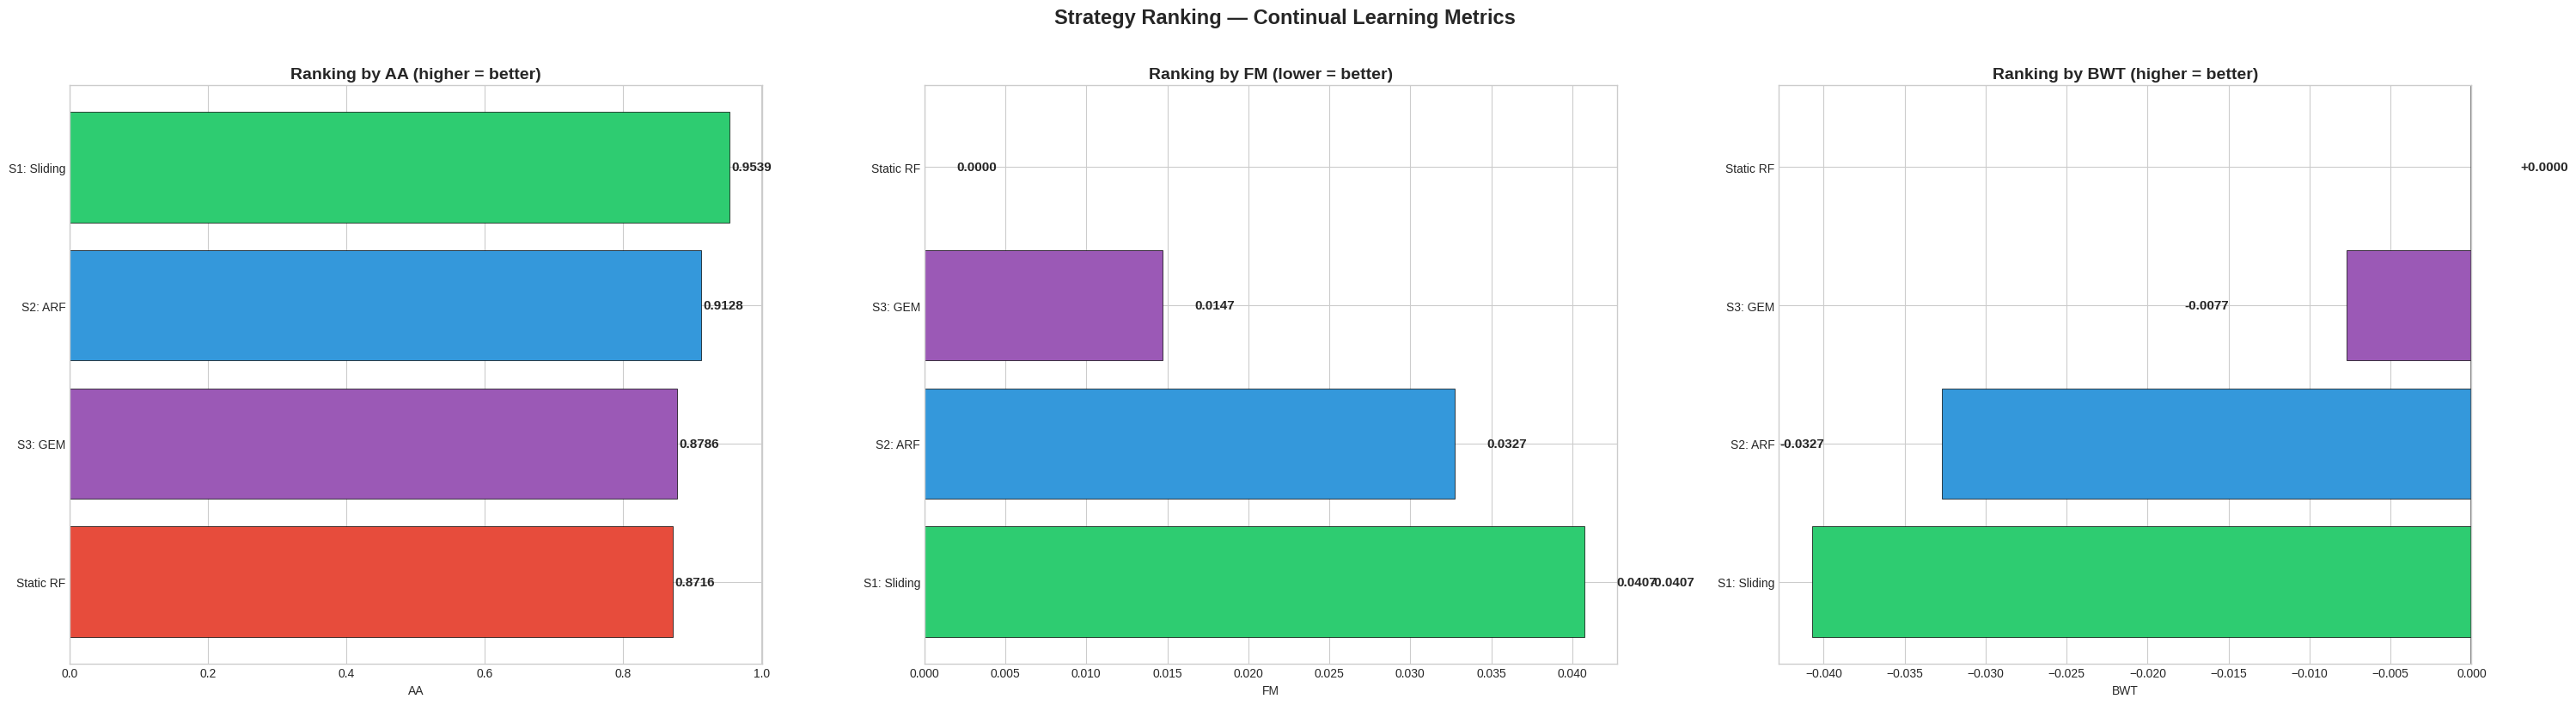

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30, 8))

sorted_aa=summary.sort_values('AA',ascending=True)
ax=axes[0]
bars=ax.barh(sorted_aa['Strategy'],sorted_aa['AA'],
             color=[strategies[n][3] for n in sorted_aa['Strategy']],edgecolor='black',linewidth=0.5)
for bar,val in zip(bars,sorted_aa['AA']):
    ax.text(val+0.003,bar.get_y()+bar.get_height()/2,f'{val:.4f}',va='center',fontsize=11,fontweight='bold')
ax.set_xlabel('AA'); ax.set_title('Ranking by AA (higher = better)',fontsize=14,fontweight='bold')

sorted_fm=summary.sort_values('FM',ascending=False)
ax=axes[1]
bars=ax.barh(sorted_fm['Strategy'],sorted_fm['FM'],
             color=[strategies[n][3] for n in sorted_fm['Strategy']],edgecolor='black',linewidth=0.5)
for bar,val in zip(bars,sorted_fm['FM']):
    ax.text(val+0.002,bar.get_y()+bar.get_height()/2,f'{val:.4f}',va='center',fontsize=11,fontweight='bold')
ax.set_xlabel('FM'); ax.set_title('Ranking by FM (lower = better)',fontsize=14,fontweight='bold')

sorted_bwt=summary.sort_values('BWT',ascending=True)
ax=axes[2]
bars=ax.barh(sorted_bwt['Strategy'],sorted_bwt['BWT'],
             color=[strategies[n][3] for n in sorted_bwt['Strategy']],edgecolor='black',linewidth=0.5)
for bar,val in zip(bars,sorted_bwt['BWT']):
    off=0.003 if val>=0 else -0.01
    ax.text(val+off,bar.get_y()+bar.get_height()/2,f'{val:+.4f}',va='center',fontsize=11,fontweight='bold')
ax.axvline(x=0,color='black',ls='-',alpha=0.5)
ax.set_xlabel('BWT'); ax.set_title('Ranking by BWT (higher = better)',fontsize=14,fontweight='bold')

plt.suptitle('Strategy Ranking — Continual Learning Metrics',fontsize=17,fontweight='bold',y=1.02)
plt.tight_layout(); plt.savefig('ranking_cl.png', dpi=150, bbox_inches='tight'); plt.show()

In [ ]:
print(f"\n{'='*100}")
print("PER-BATCH RESULTS")
print(f"{'='*100}")

bt = pd.DataFrame({
    'B': range(cfg.n_batches),
    'Late%': [f"{lf:.0%}" for lf in late_fracs],
})
for name, (df_, *_) in strategies.items():
    short = name.split(': ')[-1] if ': ' in name else name
    bt[f'{short[:8]}_Acc'] = df_['accuracy'].round(4).values
    bt[f'{short[:8]}_F1']  = df_['f1_macro'].round(4).values
print(bt.to_string(index=False))


PER-BATCH RESULTS
 B Late%  Static R_Acc  Static R_F1  Sliding_Acc  Sliding_F1  ARF_Acc  ARF_F1  GEM_Acc  GEM_F1
 0    0%        0.9796       0.9793       0.9796      0.9793   0.5500  0.3548   0.5500  0.3548
 1    0%        0.9152       0.9148       0.9152      0.9148   0.9110  0.9105   0.8806  0.8793
 2    5%        0.8923       0.8922       0.9304      0.9299   0.9191  0.9181   0.8825  0.8822
 3   25%        0.8504       0.8502       0.9401      0.9397   0.9221  0.9214   0.8869  0.8858
 4   55%        0.8482       0.8479       0.9489      0.9485   0.9291  0.9285   0.8743  0.8742
 5   75%        0.8323       0.8316       0.9488      0.9485   0.9294  0.9290   0.8769  0.8763
 6   88%        0.8264       0.8256       0.9484      0.9481   0.9275  0.9272   0.8812  0.8798
 7   95%        0.8282       0.8275       0.9467      0.9464   0.9256  0.9252   0.8863  0.8854


In [ ]:
print(f"\n{'='*60}")
print("SANITY CHECK: Official Train → Test")
print(f"{'='*60}")
mdl = RandomForestClassifier(**cfg.rf_params)
mdl.fit(X_tr_only, y_tr_only)
yp = mdl.predict(X_te_only)
print(classification_report(y_te_only, yp, target_names=['Normal','Attack'], digits=4))


SANITY CHECK: Official Train → Test
              precision    recall  f1-score   support

      Normal     0.7712    0.9791    0.8628     56000
      Attack     0.9887    0.8637    0.9220    119341

    accuracy                         0.9005    175341
   macro avg     0.8800    0.9214    0.8924    175341
weighted avg     0.9193    0.9005    0.9031    175341

